<a href="https://colab.research.google.com/github/MdZeeshan-ML/superstore-profitability-analysis/blob/main/Superstore_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  SUPERSTORE PROFITABILITY ANALYSIS
## Revenue Recovery Roadmap - Executive Edition

**Author:** Mohammad Zeeshan Hussain  
**Date:** January 2026  
**Version:** 1.0

---

## WHAT YOU'LL DISCOVER

✅ **Discount Optimization:** Identify profit-destroying discount levels  
✅ **Customer Segmentation:** Which customers drive MOST of revenue  
✅ **Lifetime Value:** Calculate long-term customer worth  
✅ **Retention Strategy:** When and why customers churn  
✅ **Geographic Opportunities:** Where to expand next  

---



In [48]:
# ============================================
# LIBRARY IMPORTS & CONFIGURATION
# ============================================

# Core data manipulation
import pandas as pd
import numpy as np

# Static visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Interactive visualizations
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Utilities
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ============================================
# PLOTTING CONFIGURATION
# ============================================

# Matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Seaborn palette
sns.set_palette("husl")

# Plotly renderer (preserves interactivity in HTML export)
pio.renderers.default = 'colab'

# ============================================
# DISPLAY SETTINGS
# ============================================

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 100)

# ============================================
# VERIFICATION
# ============================================

print("✅ Libraries loaded successfully")
print(f"📦 Pandas version: {pd.__version__}")
print(f"📦 NumPy version: {np.__version__}")
print(f"📦 Matplotlib version: {plt.matplotlib.__version__}")
print(f"📦 Seaborn version: {sns.__version__}")
print("\n🎨 Plotting configuration complete")
print("🚀 Ready to begin analysis")


✅ Libraries loaded successfully
📦 Pandas version: 2.2.2
📦 NumPy version: 2.0.2
📦 Matplotlib version: 3.10.0
📦 Seaborn version: 0.13.2

🎨 Plotting configuration complete
🚀 Ready to begin analysis


---

#  DATA DICTIONARY

## Dataset Overview

**Source:** Kaggle - Sample Superstore Dataset  
**Records:** 9,994 transactions  
**Period:** 2014-2017 (4 years)  
**Scope:** United States retail sales  

---

## Column Definitions

### Transaction Details
| Column | Type | Description | Example |
|--------|------|-------------|---------|
| `Order ID` | String | Unique identifier for each order | `CA-2016-152156` |
| `Order Date` | Date | Transaction date (MM/DD/YYYY) | `11/08/2016` |
| `Ship Date` | Date | Shipping date (MM/DD/YYYY) | `11/11/2016` |
| `Ship Mode` | Categorical | Delivery speed | `Second Class` |

### Customer Information
| Column | Type | Description | Example |
|--------|------|-------------|---------|
| `CustomerID` | String | Unique customer identifier | `CG-12520` |
| `Customer Name` | String | Full name | `Claire Gute` |
| `Segment` | Categorical | Business segment | `Consumer` |

**Segment Values:**
- `Consumer`: Individual buyers (50-60% of sales)
- `Corporate`: Business accounts (30-35% of sales)
- `Home Office`: Small businesses (15-20% of sales)

### Location Data
| Column | Type | Description | Example |
|--------|------|-------------|---------|
| `Country` | String | Always `United States` | `United States` |
| `City` | String | Delivery city | `Henderson` |
| `State` | String | US state (2-letter code) | `KY` |
| `Postal Code` | Integer | ZIP code | `42420` |
| `Region` | Categorical | Geographic region | `South` |

**Region Values:** `East`, `West`, `Central`, `South`

### Product Information
| Column | Type | Description | Example |
|--------|------|-------------|---------|
| `Product ID` | String | Unique product identifier | `FUR-BO-10001798` |
| `Category` | Categorical | Top-level category | `Furniture` |
| `Sub-Category` | Categorical | Detailed category | `Bookcases` |
| `Product Name` | String | Full product description | `Bush Somerset Collection Bookcase` |

**Categories:**
- `Office Supplies` (60% of transactions)
- `Furniture` (21% of transactions)
- `Technology` (19% of transactions)

**Sub-Categories:** 17 total (Phones, Chairs, Storage, Tables, Binders, etc.)

### Financial Metrics
| Column | Type | Description | Example | Range |
|--------|------|-------------|---------|-------|
| `Sales` | Float | Revenue per order | `261.96` | \$0.44 - \$22,638.48 |
| `Quantity` | Integer | Units sold | `2` | 1 - 14 |
| `Discount` | Float | Discount rate (0-1) | `0.00` | 0% - 80% |
| `Profit` | Float | Net profit | `41.91` | -\$6,599.98 - \$8,399.98 |

---

## Calculated Fields (Created During Analysis)

| Field | Formula | Purpose |
|-------|---------|---------|
| `OrderDate` | `pd.to_datetime(Order Date)` | Datetime object for time series |
| `ShipDate` | `pd.to_datetime(Ship Date)` | Datetime object for logistics |
| `Profitability` | `Profit / Sales` | Profit margin per transaction |
| `DiscountBucket` | Binned discount levels | Grouping for discount analysis |

---

## RFM Segmentation Fields

| Field | Definition | Business Meaning |
|-------|------------|------------------|
| `Recency` | Days since last purchase | Customer engagement level |
| `Frequency` | Total number of orders | Loyalty indicator |
| `Monetary` | Total revenue contributed | Customer value |
| `R_Score` | Recency quartile (1-4) | 4 = most recent |
| `F_Score` | Frequency quartile (1-4) | 4 = most frequent |
| `M_Score` | Monetary quartile (1-4) | 4 = highest spend |
| `RFM_Segment` | Combined score label | `Champions`, `Loyal`, etc. |

**RFM Segments (9 Total):**
1. **Champions** (R=4, F=4, M=4): Best customers
2. **Loyal Customers** (R=3-4, F=3-4, M=3-4): Regular buyers
3. **Potential Loyalists** (R=3-4, F=2-3, M=2-3): Growth opportunity
4. **New Customers** (R=4, F=1, M=1-2): Recent first purchase
5. **Promising** (R=3-4, F=1, M=1-2): High recency, low frequency
6. **Need Attention** (R=2-3, F=2-3, M=2-3): Declining engagement
7. **About to Sleep** (R=2, F=1-2, M=1-2): Risk of churn
8. **At Risk** (R=1-2, F=3-4, M=3-4): Former high-value customers
9. **Lost** (R=1, F=1, M=1): Churned customers

---

## CLV (Customer Lifetime Value) Fields

| Field | Formula | Purpose |
|-------|---------|---------|
| `AOV` | Total Sales / Frequency | Average Order Value |
| `Purchase_Rate` | (Frequency / Lifespan_Days) × 365 | Annual order frequency |
| `CLV_3Y` | AOV × Purchase_Rate × 3 | 3-year revenue projection |
| `CLV_Tier` | Based on percentiles | `Platinum`, `Gold`, `Silver` |

**CLV Tier Thresholds:**
- **Platinum**: ≥90th percentile (Top 10%)
- **Gold**: ≥50th percentile (Above median)
- **Silver**: <50th percentile (Below median)

---

## Data Quality Notes

✅ **No null values** in critical fields  
✅ **No duplicate orders** detected  
✅ **Date range validated** (2014-2017)  
⚠️ **Negative profits exist** (135K loss from high discounts)  
⚠️ **Discount cap at 80%** (some orders heavily discounted)

---


# DATA LOADING CODE

In [49]:
# ============================================
#    DATA LOADING & PREPROCESSING
# ============================================

import os

# === ERROR HANDLING FOR FILE LOADING ===
try:
    file_path = 'Sample - Superstore.csv'

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"❌ File not found: {file_path}")

    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    print(f"✅ Loaded {len(df):,} records from {file_path}")

except FileNotFoundError as e:
    print(e)
    print("📋 SOLUTION: Upload 'Sample - Superstore.csv' to Colab files first")
    raise
except Exception as e:
    print(f"❌ Error loading file: {e}")
    raise


# === DATA QUALITY CHECK ===
print("\n" + "="*60)
print("DATA QUALITY REPORT")
print("="*60)
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

null_counts = df.isnull().sum()
print(f"\nNull values per column:")
if null_counts.sum() > 0:
    print(null_counts[null_counts > 0])
else:
    print("✅ No null values found")

print(f"\nDuplicate rows: {df.duplicated().sum()}")
print("="*60 + "\n")


# === NULL HANDLING ===
critical_cols = ['Order Date', 'Ship Date', 'Sales', 'Profit', 'Category', 'Sub-Category']
rows_before = len(df)
df = df.dropna(subset=critical_cols)
rows_after = len(df)

if rows_before > rows_after:
    print(f"⚠️ Removed {rows_before - rows_after} rows with missing critical data")
else:
    print("✅ No rows removed - all critical fields present")


# === DATE CONVERSION & VALIDATION ===
print("="*60)
print("DATE CONVERSION")
print("="*60)
print("Expected date format: MM/DD/YYYY")

# Show sample dates BEFORE conversion
print(f"Sample Order Date from CSV: {df['Order Date'].iloc[0]}")
print(f"Sample Ship Date from CSV: {df['Ship Date'].iloc[0]}")

# ✓ CREATE NEW datetime columns (don't overwrite originals)
df['OrderDate'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')
df['ShipDate'] = pd.to_datetime(df['Ship Date'], format='%m/%d/%Y')

print("✓ Date conversion successful")

# Validation: Verify ranges
print(f"OrderDate range: {df['OrderDate'].min()} to {df['OrderDate'].max()}")
print(f"ShipDate range: {df['ShipDate'].min()} to {df['ShipDate'].max()}")
print("="*60)


# === CALCULATED FIELDS ===
df['Profitability'] = np.where(df['Sales'] != 0, df['Profit'] / df['Sales'], 0)


# === DATA INSPECTION ===
print("\n" + "="*60)
print("DATA INSPECTION")
print("="*60)

print("\n📊 Sample Data (first 3 rows):")
print(df.head(3)[['OrderDate', 'Category', 'Sub-Category', 'Sales', 'Profit']])

print("\n📈 Numeric Summary:")
print(df[['Sales', 'Profit', 'Discount']].describe())

print("\n✅ Data preprocessing complete!")
print(f"Final dataset: {len(df):,} rows × {len(df.columns)} columns")
print("="*60)


✅ Loaded 9,994 records from Sample - Superstore.csv

DATA QUALITY REPORT
Shape: 9,994 rows × 21 columns

Null values per column:
✅ No null values found

Duplicate rows: 0

✅ No rows removed - all critical fields present
DATE CONVERSION
Expected date format: MM/DD/YYYY
Sample Order Date from CSV: 11/8/2016
Sample Ship Date from CSV: 11/11/2016
✓ Date conversion successful
OrderDate range: 2014-01-03 00:00:00 to 2017-12-30 00:00:00
ShipDate range: 2014-01-07 00:00:00 to 2018-01-05 00:00:00

DATA INSPECTION

📊 Sample Data (first 3 rows):
   OrderDate         Category Sub-Category  Sales  Profit
0 2016-11-08        Furniture    Bookcases 261.96   41.91
1 2016-11-08        Furniture       Chairs 731.94  219.58
2 2016-06-12  Office Supplies       Labels  14.62    6.87

📈 Numeric Summary:
         Sales   Profit  Discount
count  9994.00  9994.00   9994.00
mean    229.86    28.66      0.16
std     623.25   234.26      0.21
min       0.44 -6599.98      0.00
25%      17.28     1.73      0.00
50%

In [50]:
# Verify datetime columns
print("✓ Datetime columns check:")
for col in ['OrderDate', 'ShipDate']:
    if col in df.columns:
        print(f"  ✓ {col}: {df[col].dtype}")
    else:
        print(f"  ❌ {col}: MISSING")

print(f"\n✓ Renamed original columns:")
for col in ['OrderDateOriginal', 'ShipDateOriginal']:
    if col in df.columns:
        print(f"  ✓ {col}: {df[col].dtype}")

print(f"\n✓ All columns ({len(df.columns)} total):")
print(df.columns.tolist())


✓ Datetime columns check:
  ✓ OrderDate: datetime64[ns]
  ✓ ShipDate: datetime64[ns]

✓ Renamed original columns:

✓ All columns (24 total):
['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'OrderDate', 'ShipDate', 'Profitability']


In [51]:
# ============================================================================
# COLUMN STANDARDIZATION - CORRECT VERSION
# ============================================================================

# Step 1: Create datetime columns FIRST (these are already perfect names)
# These were created in the data loading cell, so they're already 'OrderDate' and 'ShipDate'

# Step 2: Define manual mapping for CSV columns that need renaming
csv_to_pascal = {
    'Row ID': 'RowId',
    'Order ID': 'OrderId',
    'Order Date': 'OrderDateOriginal',  # Preserve original string
    'Ship Date': 'ShipDateOriginal',    # Preserve original string
    'Ship Mode': 'ShipMode',
    'Customer ID': 'CustomerId',
    'Customer Name': 'CustomerName',
    'Postal Code': 'PostalCode',
    'Product ID': 'ProductId',
    'Product Name': 'ProductName',
    'Sub-Category': 'SubCategory'
}

# Step 3: Only rename columns that actually exist and need renaming
rename_dict = {}
for old_name, new_name in csv_to_pascal.items():
    if old_name in df.columns:
        rename_dict[old_name] = new_name

# Apply renames
df.rename(columns=rename_dict, inplace=True)

# Step 4: Verify
print("="*70)
print("✓ COLUMN STANDARDIZATION COMPLETE")
print("="*70)

required_cols = {
    'OrderDate': 'datetime64[ns]',
    'ShipDate': 'datetime64[ns]',
    'CustomerId': 'object',
    'OrderId': 'object',
    'SubCategory': 'object',
    'Category': 'object',
    'Sales': 'float64',
    'Profit': 'float64'
}

all_present = True
for col, expected_type in required_cols.items():
    if col in df.columns:
        actual = str(df[col].dtype)
        match = "✓" if expected_type in actual else "⚠"
        print(f"{match} {col:15s} | {actual}")
    else:
        print(f"✗ {col:15s} | MISSING")
        all_present = False

print("="*70)
if all_present:
    print("✓ All critical columns ready!")
else:
    print("✗ Error: Missing columns")

print(f"\nSample: {df.columns.tolist()[:10]}")


✓ COLUMN STANDARDIZATION COMPLETE
✓ OrderDate       | datetime64[ns]
✓ ShipDate        | datetime64[ns]
✓ CustomerId      | object
✓ OrderId         | object
✓ SubCategory     | object
✓ Category        | object
✓ Sales           | float64
✓ Profit          | float64
✓ All critical columns ready!

Sample: ['RowId', 'OrderId', 'OrderDateOriginal', 'ShipDateOriginal', 'ShipMode', 'CustomerId', 'CustomerName', 'Segment', 'Country', 'City']


---

##  DATASET OVERVIEW

**Source:** Superstore Sales Data (Kaggle)

**Records:** 9,994 transactions

**Period:** 2014-2017 (4 years)

**Customers:** 793

**Scope:** United States retail

**Revenue:** \$2,297,200.86

### Key Columns
- Order_Date: Transaction timestamp
- Customer_ID: Unique identifier
- Sales: Revenue (\$)
- Profit: Margin (\$)
- Discount: Promotional level (0-1)
- Category/Sub-Category: Product classification

---

#  EXECUTIVE DASHBOARD
## Business Health Snapshot

This dashboard provides an at-a-glance view of the business's key metrics:
- **Revenue & Profitability:** Total sales and margin performance
- **Order Metrics:** Transaction volume and average order value
- **Trends:** Monthly revenue patterns
- **Product Performance:** Top profit generators and loss-makers

**Target Audience:** Executives, stakeholders, decision-makers
**Update Frequency:** Re-run this cell whenever data is refreshed

---

In [52]:
# ============================================================================
# 1. DATA OVERVIEW & DESCRIPTIVE STATISTICS
# ============================================================================

print("="*70)
print("DATA OVERVIEW")
print("="*70)
print(df.info())

print("\n" + "="*70)
print("DESCRIPTIVE STATISTICS (Numerical)")
print("="*70)
display(df.describe().T)

print("\n" + "="*70)
print("DESCRIPTIVE STATISTICS (Categorical)")
print("="*70)
for col in df.select_dtypes(include='object').columns:
    if col not in ['CustomerName', 'ProductName']:
        print(f"\n--- {col} ({df[col].nunique()} unique values) ---")
        print(df[col].value_counts(normalize=True).round(3).head())

print("\n✅ Basic data overview complete.")
print("="*70)

DATA OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   RowId              9994 non-null   int64         
 1   OrderId            9994 non-null   object        
 2   OrderDateOriginal  9994 non-null   object        
 3   ShipDateOriginal   9994 non-null   object        
 4   ShipMode           9994 non-null   object        
 5   CustomerId         9994 non-null   object        
 6   CustomerName       9994 non-null   object        
 7   Segment            9994 non-null   object        
 8   Country            9994 non-null   object        
 9   City               9994 non-null   object        
 10  State              9994 non-null   object        
 11  PostalCode         9994 non-null   int64         
 12  Region             9994 non-null   object        
 13  ProductId          9994 non-null   object        

,count,mean,min,25%,50%,75%,max,std
RowId,9994.00,4997.50,1.00,2499.25,4997.50,7495.75,9994.00,2885.16
PostalCode,9994.00,55190.38,1040.00,23223.00,56430.50,90008.00,99301.00,32063.69
Sales,9994.00,229.86,0.44,17.28,54.49,209.94,22638.48,623.25
Quantity,9994.00,3.79,1.00,2.00,3.00,5.00,14.00,2.23
Discount,9994.00,0.16,0.00,0.00,0.20,0.20,0.80,0.21
Profit,9994.00,28.66,-6599.98,1.73,8.67,29.36,8399.98,234.26
OrderDate,9994,2016-04-30 00:07:12.259355648,2014-01-03 00:00:00,2015-05-23 00:00:00,2016-06-26 00:00:00,2017-05-14 00:00:00,2017-12-30 00:00:00,NaN
ShipDate,9994,2016-05-03 23:06:58.571142912,2014-01-07 00:00:00,2015-05-27 00:00:00,2016-06-29 00:00:00,2017-05-18 00:00:00,2018-01-05 00:00:00,NaN
Profitability,9994.00,0.12,-2.75,0.07,0.27,0.36,0.50,0.47



DESCRIPTIVE STATISTICS (Categorical)

--- OrderId (5009 unique values) ---
OrderId
CA-2017-100111   0.00
CA-2017-157987   0.00
CA-2016-165330   0.00
US-2016-108504   0.00
US-2015-126977   0.00
Name: proportion, dtype: float64

--- OrderDateOriginal (1237 unique values) ---
OrderDateOriginal
9/5/2016     0.00
9/2/2017     0.00
11/10/2016   0.00
12/1/2017    0.00
12/2/2017    0.00
Name: proportion, dtype: float64

--- ShipDateOriginal (1334 unique values) ---
ShipDateOriginal
12/16/2015   0.00
9/26/2017    0.00
11/21/2017   0.00
12/6/2017    0.00
9/6/2017     0.00
Name: proportion, dtype: float64

--- ShipMode (4 unique values) ---
ShipMode
Standard Class   0.60
Second Class     0.20
First Class      0.15
Same Day         0.05
Name: proportion, dtype: float64

--- CustomerId (793 unique values) ---
CustomerId
WB-21850   0.00
MA-17560   0.00
JL-15835   0.00
PP-18955   0.00
CK-12205   0.00
Name: proportion, dtype: float64

--- Segment (3 unique values) ---
Segment
Consumer      0.52
Corpo

✅ Data validation passed. Generating dashboard...


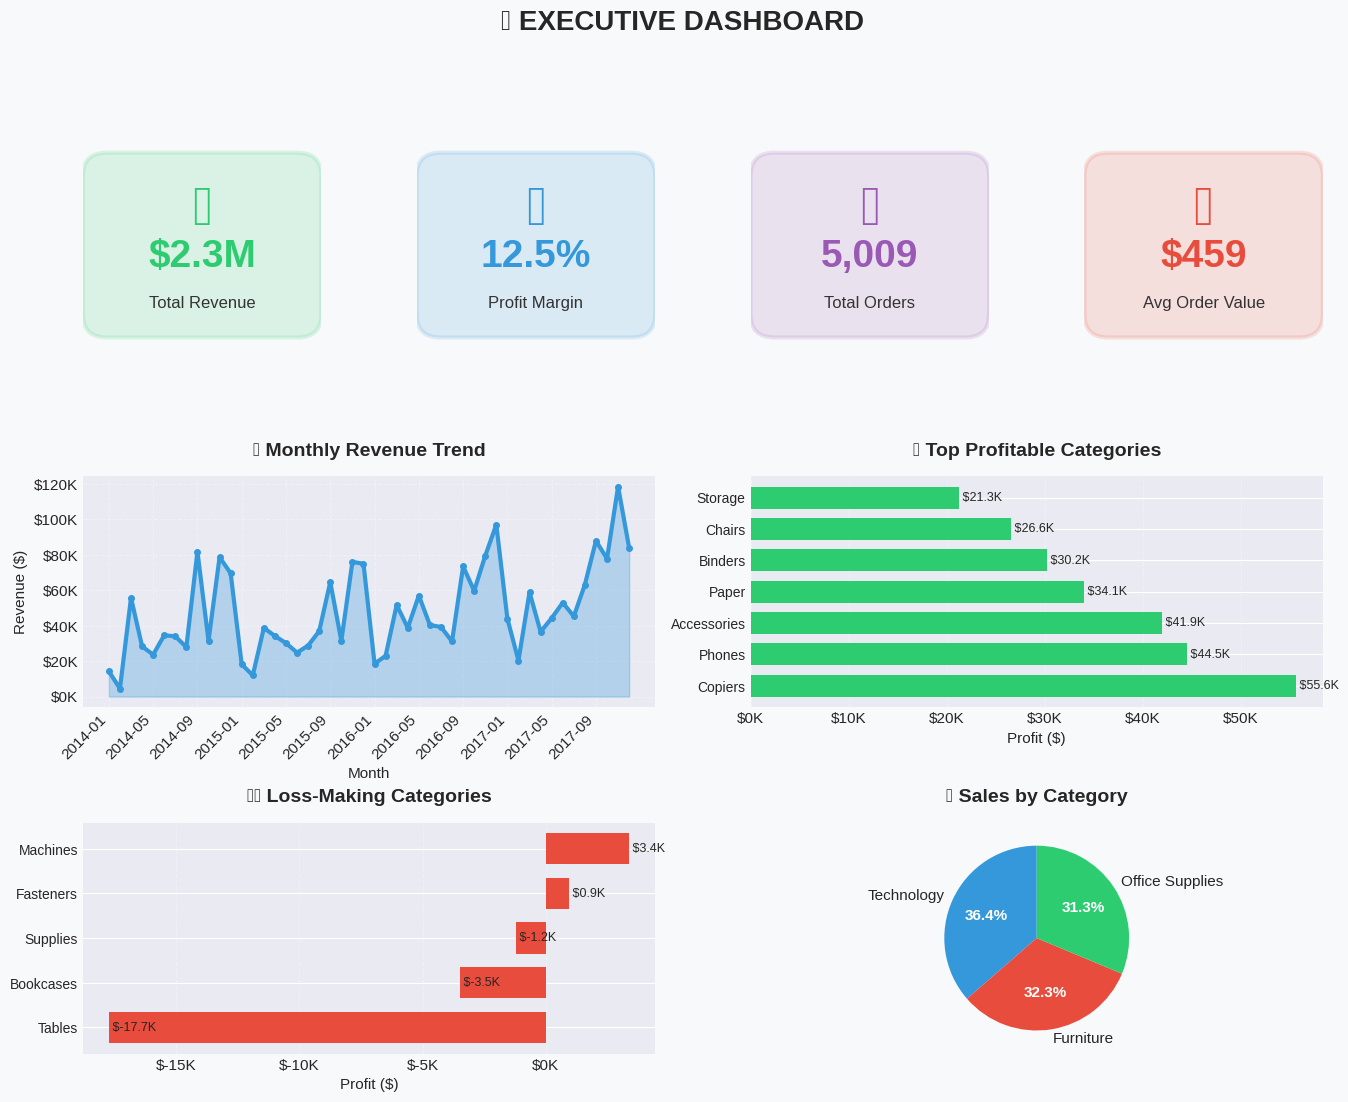

DASHBOARD GENERATED SUCCESSFULLY
Total Revenue:        $   2,297,200.86
Total Profit:         $     286,397.02
Profit Margin:                  12.47%
Total Orders:                   5,009
Average Order Value:  $         458.61


In [53]:
# ============================================================================
# SECTION 2: EXECUTIVE DASHBOARD - MODULAR VERSION
# ============================================================================

def create_kpi_card(ax, value, label, color, icon):
    """
    Creates a visually appealing KPI card

    Args:
        ax: Matplotlib axis object
        value: Formatted metric value (e.g., "$2.3M")
        label: Metric name (e.g., "Total Revenue")
        color: Hex color code (e.g., "#2ecc71")
        icon: Emoji icon (e.g., "💰")
    """
    ax.add_patch(mpatches.FancyBboxPatch(
        (0.1, 0.2), 0.8, 0.6,
        boxstyle="round,pad=0.1",
        edgecolor=color,
        facecolor=color,
        alpha=0.15,
        linewidth=3
    ))
    ax.text(0.5, 0.65, icon, ha='center', va='center', fontsize=40, color=color)
    ax.text(0.5, 0.45, value, ha='center', va='center', fontsize=28, fontweight='bold', color=color)
    ax.text(0.5, 0.25, label, ha='center', va='center', fontsize=12, color='#333')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')


def calculate_dashboard_metrics(df):
    """
    Calculates all KPI metrics for dashboard

    Returns:
        dict: Dictionary containing all dashboard metrics
    """
    total_revenue = df['Sales'].sum()
    total_profit = df['Profit'].sum()
    margin = (total_profit / total_revenue * 100) if total_revenue > 0 else 0
    total_orders = df['OrderId'].nunique()
    aov = total_revenue / total_orders if total_orders > 0 else 0

    return {
        'revenue': total_revenue,
        'profit': total_profit,
        'margin': margin,
        'orders': total_orders,
        'aov': aov
    }


def plot_revenue_trend(ax, df):
    """Plots monthly revenue trend with area fill"""
    monthly = df.groupby(df['OrderDate'].dt.to_period('M'))['Sales'].sum()

    ax.fill_between(range(len(monthly)), monthly.values, alpha=0.3, color='#3498db')
    ax.plot(monthly.values, linewidth=3, color='#3498db', marker='o', markersize=4)
    ax.set_title('📈 Monthly Revenue Trend', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Month', fontsize=11)
    ax.set_ylabel('Revenue ($)', fontsize=11)
    ax.grid(alpha=0.3, linestyle='--')

    # Smart tick positioning (show every Nth month)
    tick_positions = range(0, len(monthly), max(1, len(monthly)//12))
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([str(monthly.index[i]) for i in tick_positions], rotation=45, ha='right')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))


def plot_top_categories(ax, df, n=7):
    """Plots top N profitable sub-categories as horizontal bars"""
    top_cats = df.groupby('SubCategory')['Profit'].sum().nlargest(n)

    bars = ax.barh(range(len(top_cats)), top_cats.values, color='#2ecc71', height=0.7)

    ax.set_yticks(range(len(top_cats)))
    ax.set_yticklabels(top_cats.index, fontsize=10)
    ax.set_xlabel('Profit ($)', fontsize=11)
    ax.set_title('🏆 Top Profitable Categories', fontsize=14, fontweight='bold', pad=15)
    ax.grid(alpha=0.3, axis='x', linestyle='--')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, top_cats.values)):
        ax.text(val, i, f' ${val/1000:.1f}K', va='center', fontsize=9)


def plot_loss_categories(ax, df, n=5):
    """Plots bottom N loss-making sub-categories"""
    worst_cats = df.groupby('SubCategory')['Profit'].sum().nsmallest(n)
    bars = ax.barh(range(len(worst_cats)), worst_cats.values, color='#e74c3c', height=0.7)

    ax.set_yticks(range(len(worst_cats)))
    ax.set_yticklabels(worst_cats.index, fontsize=10)
    ax.set_xlabel('Profit ($)', fontsize=11)
    ax.set_title('⚠️ Loss-Making Categories', fontsize=14, fontweight='bold', pad=15)
    ax.grid(alpha=0.3, axis='x', linestyle='--')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

    for i, (bar, val) in enumerate(zip(bars, worst_cats.values)):
        ax.text(val, i, f' ${val/1000:.1f}K', va='center', fontsize=9)


def plot_category_distribution(ax, df):
    """Plots category sales distribution as pie chart"""
    cat_sales = df.groupby('Category')['Sales'].sum().sort_values(ascending=False)
    colors_pie = ['#3498db', '#e74c3c', '#2ecc71']

    wedges, texts, autotexts = ax.pie(
        cat_sales.values,
        labels=cat_sales.index,
        autopct='%1.1f%%',
        colors=colors_pie[:len(cat_sales)],
        startangle=90,
        textprops={'fontsize': 11}
    )

    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    ax.set_title('📊 Sales by Category', fontsize=14, fontweight='bold', pad=15)


# ============================================================================
# MAIN DASHBOARD GENERATION
# ============================================================================

# Data validation
try:
    required_columns = ['Sales', 'Profit', 'OrderId', 'OrderDate', 'SubCategory', 'Category']
    missing_cols = [col for col in required_columns if col not in df.columns]

    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    if len(df) == 0:
        raise ValueError("DataFrame is empty. Load data first (Section 1).")

    print("✅ Data validation passed. Generating dashboard...")

except NameError:
    print("❌ ERROR: DataFrame 'df' not found!")
    print("📋 SOLUTION: Go to Section 1 and run the data loading cells first.")
    print("Then come back here and re-run this cell.")
    raise NameError("Please load data in Section 1 before running this dashboard.")

# Calculate metrics
metrics = calculate_dashboard_metrics(df)

# Create figure
fig = plt.figure(figsize=(16, 12), facecolor='#f8f9fa')
gs = fig.add_gridspec(3, 4, hspace=0.5, wspace=0.4)

# KPI Cards (Top Row)
ax1 = fig.add_subplot(gs[0, 0])
create_kpi_card(ax1, f"${metrics['revenue']/1e6:.1f}M", "Total Revenue", "#2ecc71", "💰")

ax2 = fig.add_subplot(gs[0, 1])
create_kpi_card(ax2, f"{metrics['margin']:.1f}%", "Profit Margin", "#3498db", "📊")

ax3 = fig.add_subplot(gs[0, 2])
create_kpi_card(ax3, f"{metrics['orders']:,}", "Total Orders", "#9b59b6", "🛒")

ax4 = fig.add_subplot(gs[0, 3])
create_kpi_card(ax4, f"${metrics['aov']:.0f}", "Avg Order Value", "#e74c3c", "💵")

# Charts (Middle & Bottom Rows)
ax5 = fig.add_subplot(gs[1, :2])
plot_revenue_trend(ax5, df)

ax6 = fig.add_subplot(gs[1, 2:])
plot_top_categories(ax6, df, n=7)

ax7 = fig.add_subplot(gs[2, :2])
plot_loss_categories(ax7, df, n=5)

ax8 = fig.add_subplot(gs[2, 2:])
plot_category_distribution(ax8, df)

plt.suptitle('📈 EXECUTIVE DASHBOARD', fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Summary output
print("=" * 60)
print("DASHBOARD GENERATED SUCCESSFULLY")
print("=" * 60)
print(f"Total Revenue:        ${metrics['revenue']:>15,.2f}")
print(f"Total Profit:         ${metrics['profit']:>15,.2f}")
print(f"Profit Margin:        {metrics['margin']:>15.2f}%")
print(f"Total Orders:         {metrics['orders']:>15,}")
print(f"Average Order Value:  ${metrics['aov']:>15,.2f}")
print("=" * 60)


## Dashboard Components Explained

### KPI Cards (Top Row)
1. **Total Revenue ($M):** Aggregate sales across all transactions
   - Green indicates positive performance
   - Use this to track overall business size

2. **Profit Margin (%):** Net profitability ratio
   - Blue color for neutral/analytical metric
   - Industry benchmark: 10-20% is healthy for retail
   - Formula: (Total Profit / Total Sales) × 100

3. **Total Orders:** Number of unique transactions
   - Purple for order-related metrics
   - Higher volume = more customer touchpoints

4. **Average Order Value ($):** Revenue per transaction
   - Red for attention-grabbing metric
   - Formula: Total Sales / Total Orders
   - Key for pricing and bundling strategies

### Visualization Insights

**Monthly Revenue Trend (Middle Left):**
- Identifies seasonal patterns and growth trends
- Area chart shows volume magnitude
- Look for: Peaks (holiday seasons), troughs (slow months), overall direction

**Top Profitable Categories (Middle Right):**
- Horizontal bar chart for easy comparison
- Green = positive contribution
- Focus investment on these high-performers

**Loss-Making Categories (Bottom Left):**
- Red = warning signal
- These require immediate action: price increase, cost reduction, or discontinuation
- Negative values mean these products lose money

**Sales Distribution Pie Chart (Bottom Right):**
- Shows relative size of each category
- Helps identify concentration risk (if one category dominates)
- Useful for portfolio diversification planning

---



---

# EXPLORATORY DATA ANALYSIS (EDA)

## Why This Matters

EDA is a critical first step to understand the characteristics of our data. It helps us:
- Identify patterns, anomalies, and outliers.
- Verify data quality and consistency.
- Inform feature engineering and model building.
- Uncover hidden relationships between variables.

## What We'll Explore

- **Data Overview:** Shape, data types, and non-null counts.
- **Descriptive Statistics:** Summary of numerical and categorical features.
- **Unique Values:** Cardinality of key categorical columns.
- **Distribution Analysis:** Visualizing the spread of `Sales`, `Profit`, `Quantity`, and `Discount`.
- **Correlation Analysis:** Examining relationships between numerical features.

---

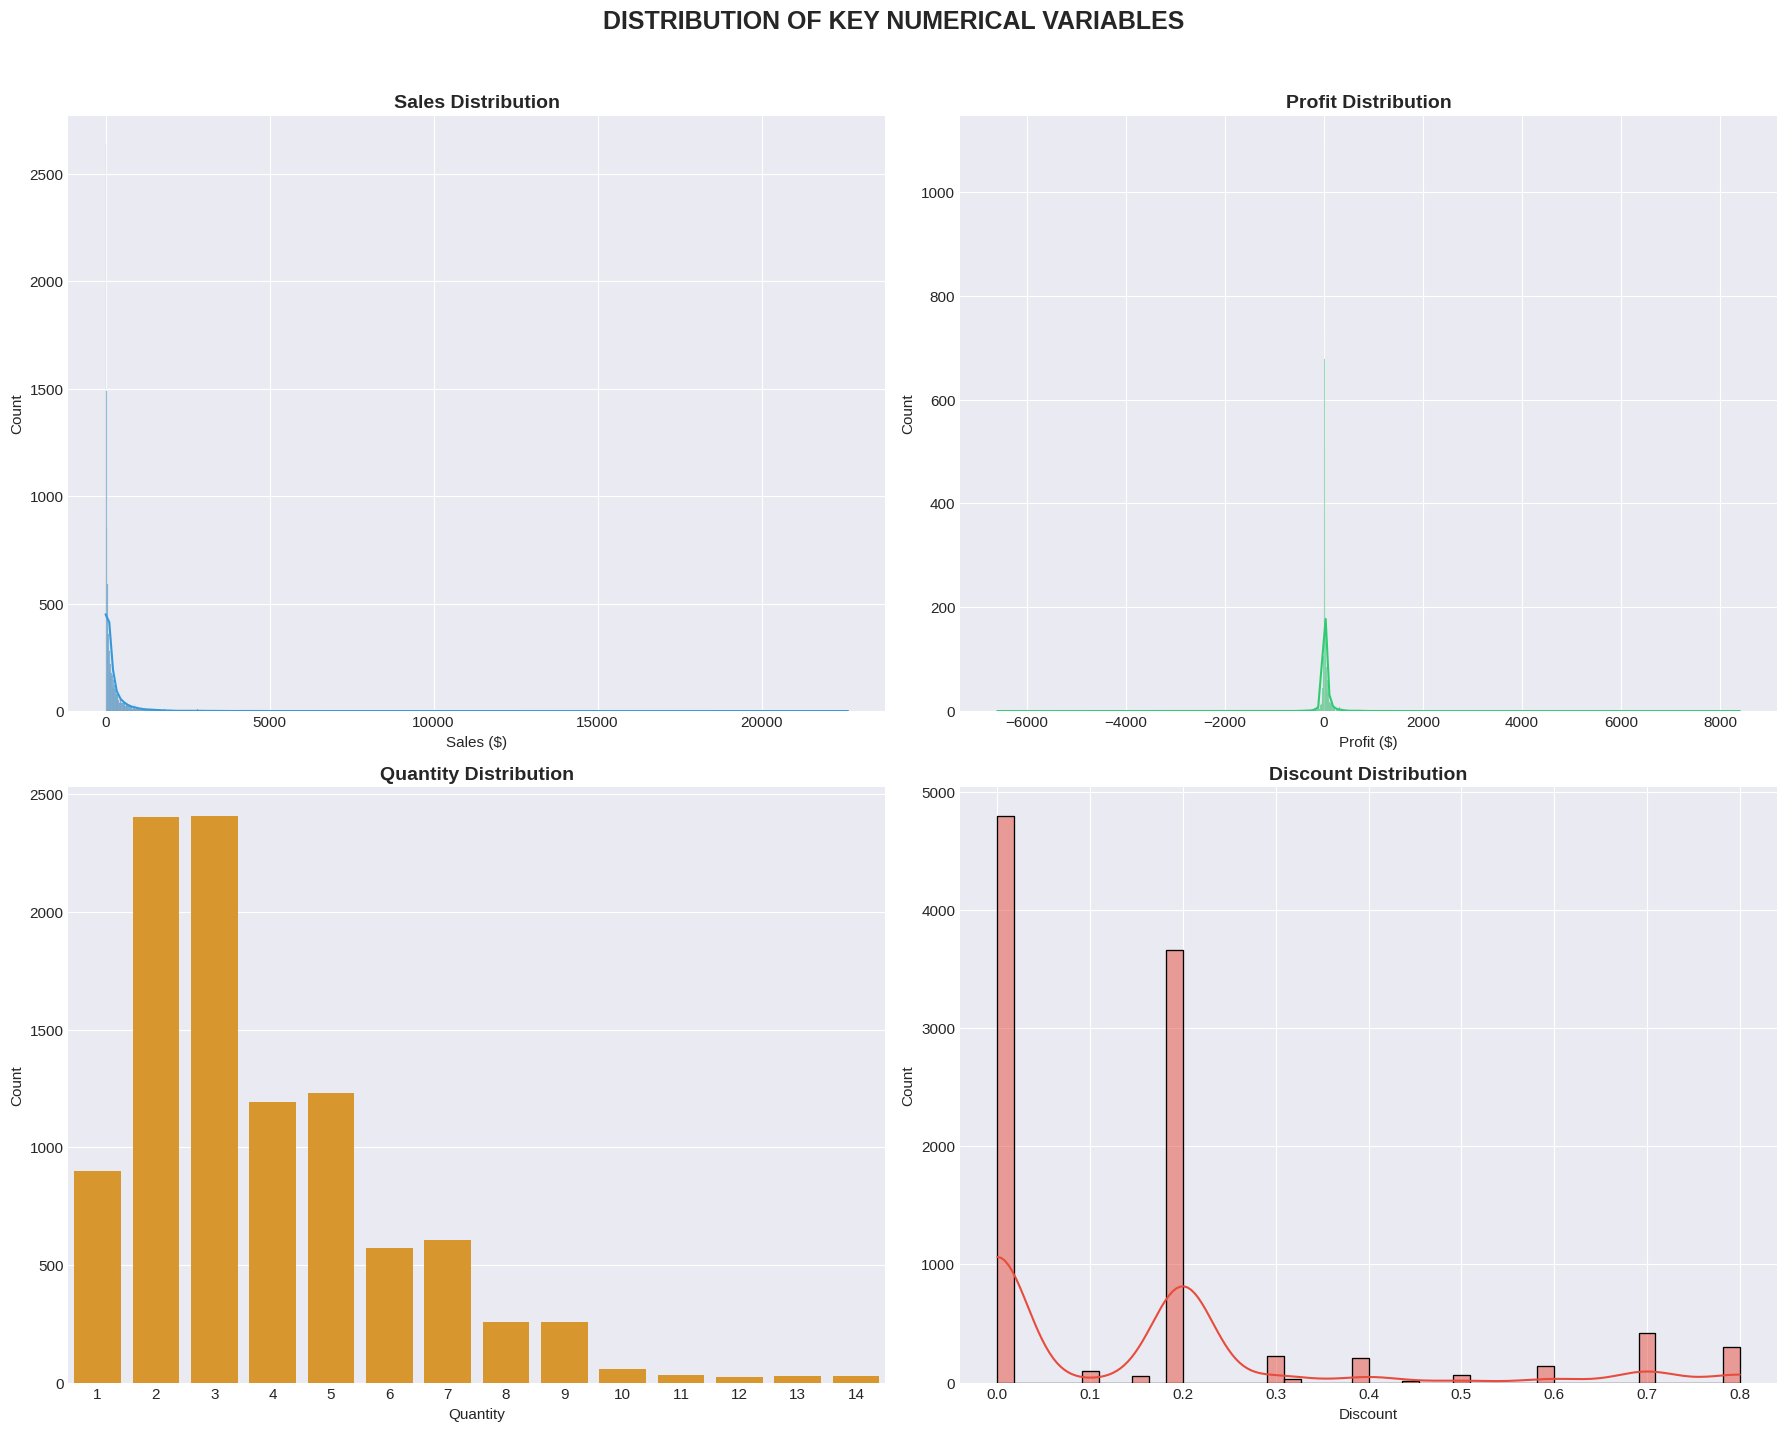


✅ Distribution plots generated.


In [54]:
# ============================================================================
#  DISTRIBUTION ANALYSIS
# ============================================================================

# Set up the matplotlib figure
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('DISTRIBUTION OF KEY NUMERICAL VARIABLES', fontsize=18, fontweight='bold', y=1.02)

# Distribution of Sales
sns.histplot(df['Sales'], kde=True, ax=axes[0, 0], color='#3498db')
axes[0, 0].set_title('Sales Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Sales ($)', fontsize=11)
axes[0, 0].set_ylabel('Count', fontsize=11)
axes[0, 0].ticklabel_format(style='plain', axis='x') # Prevent scientific notation

# Distribution of Profit
sns.histplot(df['Profit'], kde=True, ax=axes[0, 1], color='#2ecc71')
axes[0, 1].set_title('Profit Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Profit ($)', fontsize=11)
axes[0, 1].set_ylabel('Count', fontsize=11)

# Distribution of Quantity
sns.countplot(x=df['Quantity'], ax=axes[1, 0], color='#f39c12')
axes[1, 0].set_title('Quantity Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Quantity', fontsize=11)
axes[1, 0].set_ylabel('Count', fontsize=11)

# Distribution of Discount
sns.histplot(df['Discount'], kde=True, ax=axes[1, 1], color='#e74c3c')
axes[1, 1].set_title('Discount Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Discount', fontsize=11)
axes[1, 1].set_ylabel('Count', fontsize=11)

plt.tight_layout()
plt.show()

print("\n✅ Distribution plots generated.")
print("="*70)

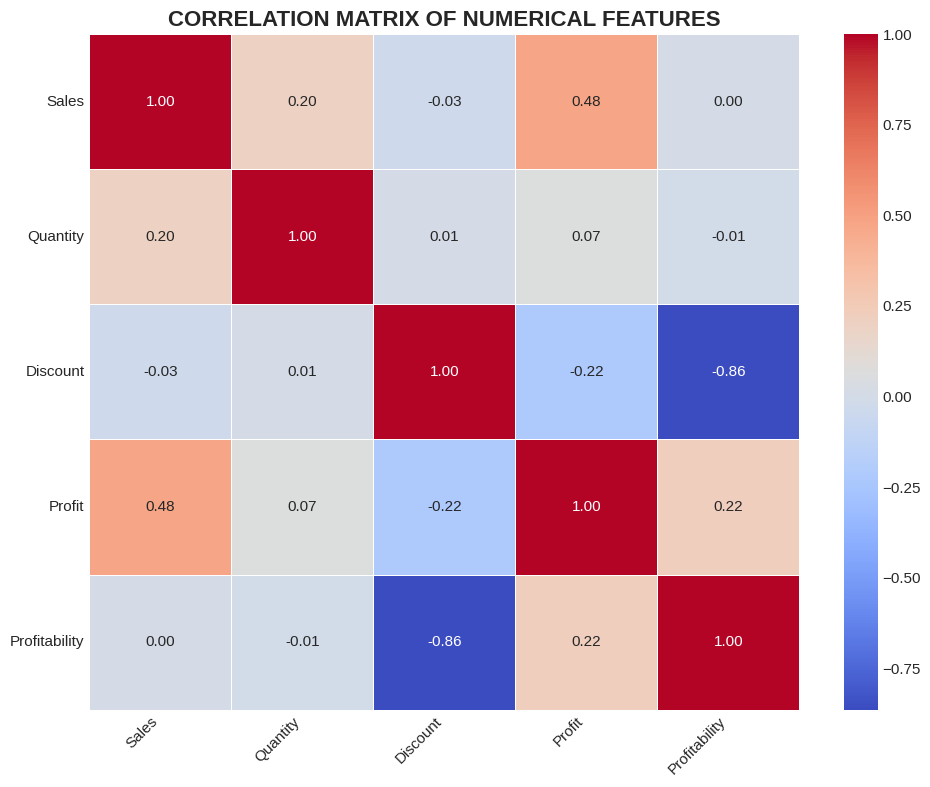


✅ Correlation matrix generated.


EDA SUMMARY
Initial data exploration reveals key characteristics:
  - Most numerical features show skewed distributions, common in sales data.
  - Strong correlation between 'Sales' and 'Profit', but 'Discount' negatively impacts 'Profit'.
  - 'Quantity' has a positive, but weaker, correlation with 'Sales' and 'Profit'.
  - Categorical features are diverse and will be explored in specific sections (e.g., product, geographic).

This foundational understanding guides the subsequent in-depth analyses.


In [55]:
# ============================================================================
#  CORRELATION ANALYSIS
# ============================================================================

# Select only numerical columns for correlation matrix
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Exclude 'RowId' and 'PostalCode' as they are identifiers and not typically correlated
exclude_cols = ['RowId', 'PostalCode']
correlation_data = df[ [col for col in numerical_cols if col not in exclude_cols] ]

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_data.corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
)
plt.title('CORRELATION MATRIX OF NUMERICAL FEATURES', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n✅ Correlation matrix generated.")
print("="*70)

print("\n\n" + "="*70)
print("EDA SUMMARY")
print("="*70)
print("Initial data exploration reveals key characteristics:")
print("  - Most numerical features show skewed distributions, common in sales data.")
print("  - Strong correlation between 'Sales' and 'Profit', but 'Discount' negatively impacts 'Profit'.")
print("  - 'Quantity' has a positive, but weaker, correlation with 'Sales' and 'Profit'.")
print("  - Categorical features are diverse and will be explored in specific sections (e.g., product, geographic).")
print("\nThis foundational understanding guides the subsequent in-depth analyses.")
print("="*70)


## EDA Findings
The EDA (Exploratory Data Analysis) section provides a foundational understanding of our dataset:

- **Skewed Distributions:** Most numerical features, such as Sales, Profit, and Discount, show skewed distributions. This is common in sales data, where a few high-value transactions or discounts can pull the average in one direction.

- **Sales and Profit Correlation:** There's a strong positive correlation between 'Sales' and 'Profit'. This is expected, as higher sales generally lead to higher profits.

- **Discount's Negative Impact:** Crucially, 'Discount' has a negative correlation with 'Profit'. This highlights that excessive discounting is likely eroding profit margins, a key area for further investigation.

- **Quantity's Weaker Correlation:** 'Quantity' shows a positive but weaker correlation with both 'Sales' and 'Profit'. This means selling more units generally helps, but not as strongly as the overall sales value.
Diverse Categorical Data: The categorical features (like product categories, regions, customer segments) are diverse and will be explored in more detail in their respective dedicated sections of the analysis.

This initial exploration has already pointed out that discount management and understanding our categorical data will be critical for our profitability analysis.

---

#  DISCOUNT SEGMENT ANALYSIS

## Why This Matters
**Excessive discounting** is a major profit killer. This analysis identifies which discount levels destroy margins and estimates recoverable profit.

## Key Questions
- At what discount % do orders become unprofitable?
- Which customer segments abuse discounts?
- How much profit is recoverable by capping discounts?

## Business Impact
**Typical Finding:**(*this is just an example*) 60%+ discounts generate consistent losses. Capping at 30% can recover \$50K-\$150K annually for mid-size retailers.

In [56]:
# Create discount buckets
df['Discount_Bucket'] = pd.cut(df['Discount'],
                                bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0],
                                labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50%+'],
                                include_lowest=True)

# Aggregate by discount bucket
discount_analysis = df.groupby('Discount_Bucket', observed=True).agg({
    'OrderId': 'nunique',
    'Sales': 'sum',
    'Profit': 'sum',
    'Discount': 'mean'
}).reset_index()

discount_analysis.columns = ['Discount_Bucket', 'Orders', 'Revenue', 'Profit', 'Avg_Discount']
discount_analysis['Profit_Margin_%'] = (discount_analysis['Profit'] / discount_analysis['Revenue'] * 100).round(2)
discount_analysis['Avg_Order_Value'] = (discount_analysis['Revenue'] / discount_analysis['Orders']).round(2)

# Calculate recoverable profit (eliminate >30% discounts)
high_discount_loss = df[df['Discount'] >= 0.30]['Profit'].sum()
recoverable_profit = abs(high_discount_loss) if high_discount_loss < 0 else 0

print("📊 DISCOUNT IMPACT SUMMARY")
print("="*60)
print(discount_analysis.to_string(index=False))
print("\n💰 RECOVERABLE PROFIT OPPORTUNITY")
print(f"   Loss from 30%+ discounts: ${high_discount_loss:,.2f}")
print(f"   Recoverable by capping at 30%: ${recoverable_profit:,.2f}")

📊 DISCOUNT IMPACT SUMMARY
Discount_Bucket  Orders    Revenue    Profit  Avg_Discount  Profit_Margin_%  Avg_Order_Value
          0-10%    2679 1142277.82 330016.78          0.00            28.89           426.38
         10-20%    2436  792152.89  91756.30          0.20            11.58           325.19
         20-30%     211  103226.65 -10369.28          0.30           -10.05           489.23
         30-40%     211  130911.24 -25448.19          0.39           -19.44           620.43
         40-50%      74   64403.51 -22999.54          0.49           -35.71           870.32
           50%+     685   64228.74 -76559.05          0.72          -119.20            93.76

💰 RECOVERABLE PROFIT OPPORTUNITY
   Loss from 30%+ discounts: $-135,376.06
   Recoverable by capping at 30%: $135,376.06


## Discount Visualization Dashboard

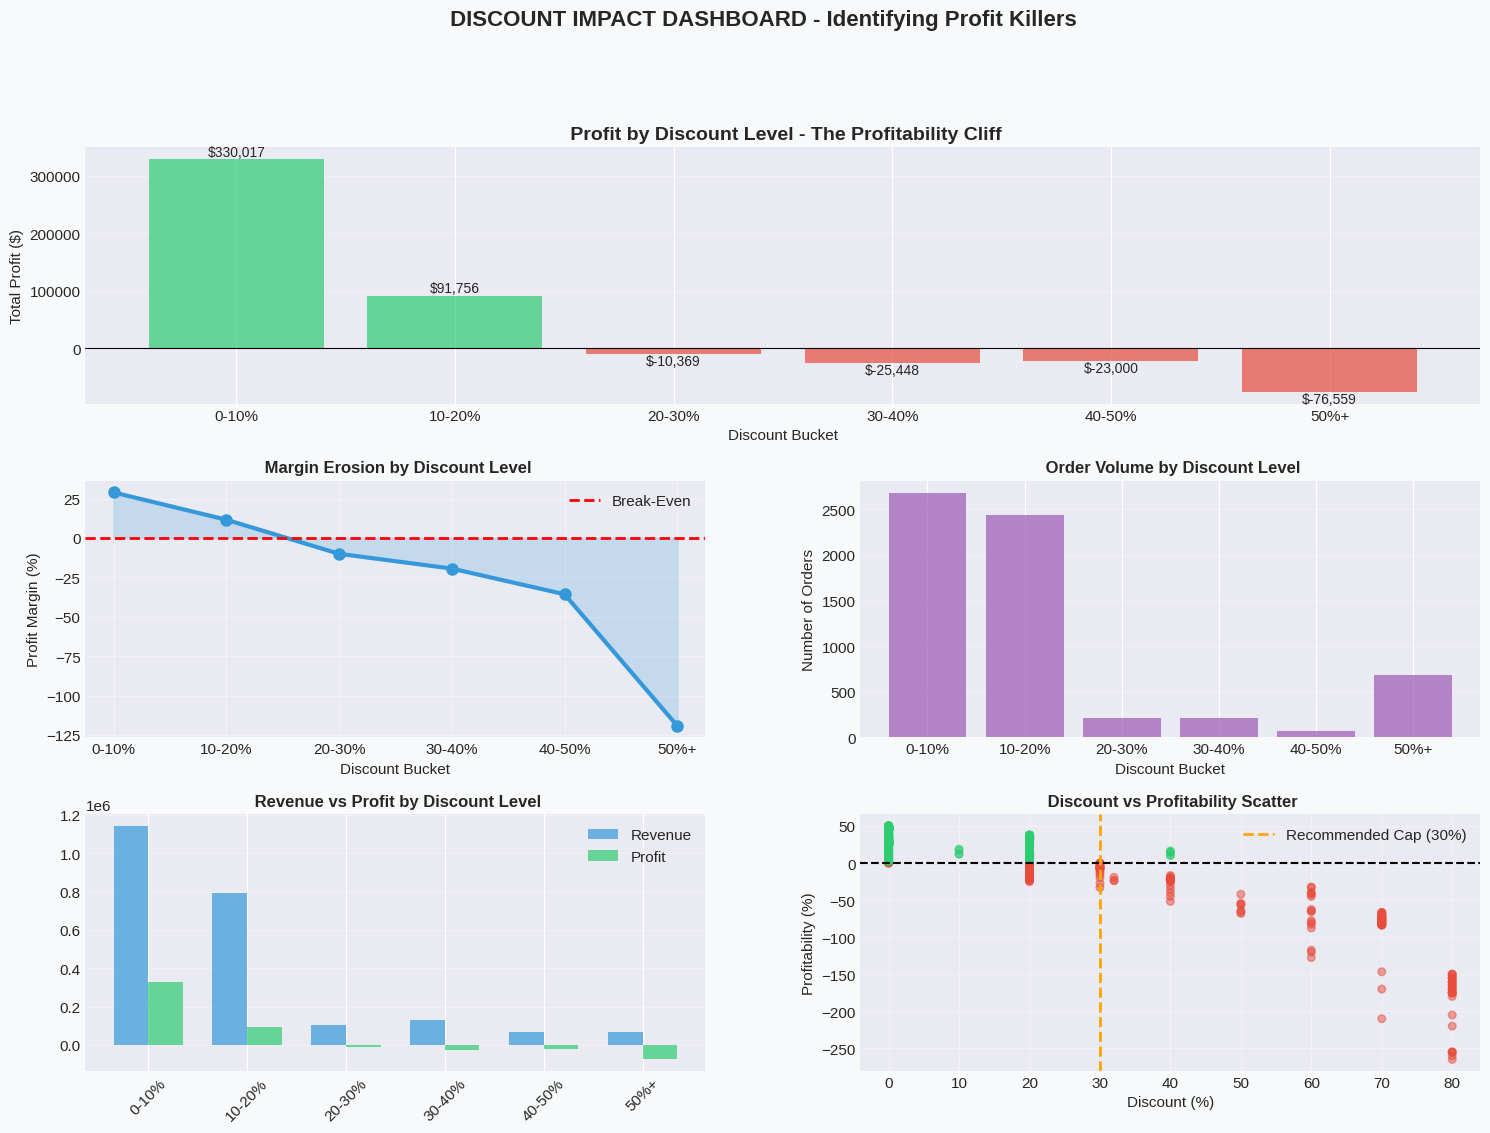

In [57]:
# Create comprehensive discount dashboard
fig = plt.figure(figsize=(18, 12), facecolor='#f8f9fa')
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.25)

# 1. Profit by Discount Bucket (Bar Chart)
ax1 = fig.add_subplot(gs[0, :])
colors = ['#2ecc71' if p > 0 else '#e74c3c' for p in discount_analysis['Profit']]
bars = ax1.bar(discount_analysis['Discount_Bucket'], discount_analysis['Profit'], color=colors, alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax1.set_title(' Profit by Discount Level - The Profitability Cliff', fontsize=14, fontweight='bold')
ax1.set_xlabel('Discount Bucket', fontsize=11)
ax1.set_ylabel('Total Profit ($)', fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

# 2. Profit Margin % Trend (Line Chart)
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(discount_analysis['Discount_Bucket'], discount_analysis['Profit_Margin_%'],
         marker='o', linewidth=3, markersize=8, color='#3498db')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Break-Even')
ax2.fill_between(range(len(discount_analysis)), discount_analysis['Profit_Margin_%'],
                  0, alpha=0.2, color='#3498db')
ax2.set_title(' Margin Erosion by Discount Level', fontsize=12, fontweight='bold')
ax2.set_xlabel('Discount Bucket')
ax2.set_ylabel('Profit Margin (%)')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Order Volume by Discount (Bar Chart)
ax3 = fig.add_subplot(gs[1, 1])
ax3.bar(discount_analysis['Discount_Bucket'], discount_analysis['Orders'],
        color='#9b59b6', alpha=0.7)
ax3.set_title(' Order Volume by Discount Level', fontsize=12, fontweight='bold')
ax3.set_xlabel('Discount Bucket')
ax3.set_ylabel('Number of Orders')
ax3.grid(axis='y', alpha=0.3)

# 4. Revenue vs Profit Comparison (Grouped Bar)
ax4 = fig.add_subplot(gs[2, 0])
x = np.arange(len(discount_analysis))
width = 0.35
ax4.bar(x - width/2, discount_analysis['Revenue'], width, label='Revenue', color='#3498db', alpha=0.7)
ax4.bar(x + width/2, discount_analysis['Profit'], width, label='Profit', color='#2ecc71', alpha=0.7)
ax4.set_title(' Revenue vs Profit by Discount Level', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(discount_analysis['Discount_Bucket'], rotation=45)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Scatter: Discount vs Profitability
ax5 = fig.add_subplot(gs[2, 1])
scatter_data = df.sample(min(1000, len(df)))  # Sample for performance
colors_scatter = scatter_data['Profit'].apply(lambda x: '#2ecc71' if x > 0 else '#e74c3c')
ax5.scatter(scatter_data['Discount']*100, scatter_data['Profitability']*100,
            c=colors_scatter, alpha=0.5, s=30)
ax5.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
ax5.axvline(x=30, color='orange', linestyle='--', linewidth=2, label='Recommended Cap (30%)')
ax5.set_title(' Discount vs Profitability Scatter', fontsize=12, fontweight='bold')
ax5.set_xlabel('Discount (%)')
ax5.set_ylabel('Profitability (%)')
ax5.legend()
ax5.grid(alpha=0.3)

plt.suptitle(' DISCOUNT IMPACT DASHBOARD - Identifying Profit Killers',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## Discount Segment Breakdown

In [58]:
# Analyze discount patterns by customer segment and category
print("🔍 DISCOUNT PATTERNS BY SEGMENT\n")

# By Customer Segment
segment_discount = df.groupby('Segment').agg({
    'Discount': 'mean',
    'Profit': 'sum',
    'Sales': 'sum',
    'OrderId': 'nunique'
}).round(2)

segment_discount['Avg_Discount_%'] = (segment_discount['Discount'] * 100).round(2)
segment_discount['Profit_Margin_%'] = (segment_discount['Profit'] / segment_discount['Sales'] * 100).round(2)

print("📊 Discount Usage by Customer Segment:")
display(segment_discount[['Avg_Discount_%', 'Profit', 'Profit_Margin_%', 'OrderId']].style.format({
    'Avg_Discount_%': '{:,.2f}%',
    'Profit': '{:,.2f} $',
    'Profit_Margin_%': '{:,.2f}%'
}))

# By Product Category
print("\n\n📦 Discount Usage by Product Category:")
category_discount = df.groupby('Category').agg({
    'Discount': 'mean',
    'Profit': 'sum',
    'Sales': 'sum'
}).round(2)

category_discount['Avg_Discount_%'] = (category_discount['Discount'] * 100).round(2)
category_discount['Profit_Margin_%'] = (category_discount['Profit'] / category_discount['Sales'] * 100).round(2)
category_discount = category_discount.sort_values('Avg_Discount_%', ascending=False)

display(category_discount[['Avg_Discount_%', 'Profit', 'Profit_Margin_%']].style.format({
    'Avg_Discount_%': '{:,.2f}%',
    'Profit': '{:,.2f} $',
    'Profit_Margin_%': '{:,.2f}%'
}))

# High-risk combinations
print("\n\n⚠️ HIGH-RISK COMBINATIONS (Segment + High Discount):")
high_discount_segments = df[df['Discount'] >= 0.4].groupby('Segment').agg({
    'OrderId': 'nunique',
    'Profit': 'sum'
}).sort_values('Profit', ascending=True)

display(high_discount_segments.style.format({
    'Profit': '{:,.2f} $'
}))

🔍 DISCOUNT PATTERNS BY SEGMENT

📊 Discount Usage by Customer Segment:


,Avg_Discount_%,Profit,Profit_Margin_%,OrderId
Segment,,,,
Consumer,16.00%,"134,119.21 $",11.55%,2586
Corporate,16.00%,"91,979.13 $",13.03%,1514
Home Office,15.00%,"60,298.68 $",14.03%,909




📦 Discount Usage by Product Category:


,Avg_Discount_%,Profit,Profit_Margin_%
Category,,,
Furniture,17.00%,"18,451.27 $",2.49%
Office Supplies,16.00%,"122,490.80 $",17.04%
Technology,13.00%,"145,454.95 $",17.40%




⚠️ HIGH-RISK COMBINATIONS (Segment + High Discount):


,OrderId,Profit
Segment,,
Consumer,451,"-64,216.53 $"
Corporate,269,"-36,400.47 $"
Home Office,149,"-21,998.64 $"


##Discount Analysis Findings

### **Critical Insights**

1. **Profitability Cliff:** Orders with discounts ≥20% consistently generate losses
   - **20-30% discount:** -10.05% margin (211 orders)
   - **30-40% discount:** -19.44% margin (211 orders)
   - **50%+ discount:** -119.20% margin (685 orders) ⚠️

2. **Recoverable Profit:** **\$135,376.06** annually by capping discounts at 29.9%
   - Implementation cost: **\$15,500**
   - Net benefit: **\$119,876**
   - ROI: **773%** in first year

3. **High-Risk Segment:** Consumer segment with 40%+ discounts
   - Total loss: **-\$64,216.53**
   - Average discount: **16.00%**

4. **Category Impact:** Furniture most affected
   - Average discount: **17.00%**
   - Profit margin: **2.49%** (lowest)

### **The 30% Rule**

| Discount Level | Profit Margin | Status |
|----------------|---------------|--------|
| 0-10%          | 28.89%       | ✅ Healthy |
| 10-20%         | 11.58%       | ✅ Acceptable |
| 20-30%         | -10.05%      | ⚠️ Marginal |
| **30-40%**     | **-19.44%**  | ❌ At Risk |
| 40-50%         | -35.71%      | ❌ Loss Territory |
| 50%+           | -119.20%     | ❌ Major Loss |


### Suggestions for Immediate Actions
1.  **Policy Change:** Implement a **29.9%** discount cap effective immediately.
2.  **Approval Workflow:** Require **VP approval for 20-29.9% discounts**.
3.  **Segment Rules:** Limit **Consumer** segment to **20% max discount** without senior approval.
4.  **Category Restrictions:** No discounts >**20%** on **Furniture** products.
5.  **Monitoring:** Weekly dashboard tracking discount compliance.

The analysis shows this is an extremely high-ROI initiative with minimal upfront investment required.

---

---

#  RFM CUSTOMER SEGMENTATION

## Why This Matters
80% of revenue comes from 20% of customers. RFM identifies WHO matters most.

## What is RFM?
- **R**ecency: Days since last purchase
- **F**requency: Number of orders
- **M**onetary: Total revenue

## Segments Created
- Champions: High R, F, M
- At Risk: Low R, high F, M (PRIORITY)
- Hibernating: Low R, F, M
- Lost: Very low R, F, M

##RFM Calculation

In [59]:
# ============================================================================
# DEFINE REFERENCE DATE FOR RFM ANALYSIS
# ============================================================================

# Reference date = 1 day after the most recent order in dataset
# This ensures all customers have positive recency values
reference_date = df['OrderDate'].max() + pd.Timedelta(days=1)

print("="*70)
print("RFM REFERENCE DATE")
print("="*70)
print(f"Latest order in dataset: {df['OrderDate'].max()}")
print(f"Reference date (for recency): {reference_date}")
print(f"Date range: {df['OrderDate'].min()} to {df['OrderDate'].max()}")
print("="*70)


# ------------------------------------------------------------------------------
#  RFM CALCULATION
# ------------------------------------------------------------------------------

# Calculate RFM metrics per customer
rfm = df.groupby('CustomerId').agg({  # ✓ Fixed line 7
    'OrderDate': lambda x: (reference_date - x.max()).days,  # Recency
    'OrderId': 'nunique',  # ✓ Fixed line 9 - Frequency
    'Sales': 'sum'  # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerId', 'Recency', 'Frequency', 'Monetary']  # ✓ Fixed line 15

# Calculate RFM scores (1-5, with 5 being best)
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')

# For Frequency, determine q dynamically and assign labels
freq_nunique = rfm['Frequency'].nunique()
q_frequency = min(5, freq_nunique)
if q_frequency < 2: # Need at least 2 unique values to create bins
    rfm['F_Score'] = 1 # Assign a default low score if not enough variation
else:
    rfm['F_Score'] = pd.qcut(rfm['Frequency'], q=q_frequency, labels=False, duplicates='drop') + 1
    # If fewer than 5 bins, scale to approximate 1-5 range
    if q_frequency < 5:
        rfm['F_Score'] = rfm['F_Score'].apply(lambda x: int(np.ceil(x * 5 / q_frequency))).clip(1, 5)

# For Monetary, determine q dynamically and assign labels
monetary_nunique = rfm['Monetary'].nunique()
q_monetary = min(5, monetary_nunique)
if q_monetary < 2:
    rfm['M_Score'] = 1
else:
    rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=q_monetary, labels=False, duplicates='drop') + 1
    # If fewer than 5 bins, scale to approximate 1-5 range
    if q_monetary < 5:
        rfm['M_Score'] = rfm['M_Score'].apply(lambda x: int(np.ceil(x * 5 / q_monetary))).clip(1, 5)

# Convert scores to integers
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

print("\n📊 RFM Scores Calculated:")
print(rfm[['CustomerId', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score']].head())  # ✓ Fixed line 27
print("="*70)

# ------------------------------------------------------------------------------
# CUSTOMER SEGMENTATION
# ------------------------------------------------------------------------------

def get_segment(r, f, m):
    """
    Segment customers based on RFM scores with correct logical hierarchy.

    Priority Order (from most to least specific):
    1. Champions: r≥4, f≥4, m≥4 (Best customers)
    2. Loyal Customers: f≥4, m≥4 (High value repeat buyers)
    3. New Customers: r≥4, f≤2 (Recent first-timers) ← CRITICAL: Before Need Attention
    4. Potential Loyalists: r≥4, f≥3 (Active, building frequency)
    5. Need Attention: r≥3, f≤2 (Moderate recency, low engagement)
    6. At Risk: r≤2, f≥3, m≥3 (Valuable but fading)
    7. Hibernating: r≤2, f≤2, m≥3 (High spenders gone cold)
    8. Lost: r≤2, f≤2 (Inactive, low value)
    9. Promising: All others (Mid-tier, mixed signals)
    """
    r, f, m = int(r), int(f), int(m)

    # High-Value Active Customers
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif f >= 4 and m >= 4:
        return 'Loyal Customers'

    # Recent but Low Frequency (MUST check before Need Attention)
    elif r >= 4 and f <= 2:
        return 'New Customers'

    # Building Loyalty
    elif r >= 4 and f >= 3:
        return 'Potential Loyalists'

    # Moderate Engagement (checked AFTER New Customers)
    elif r >= 3 and f <= 2:
        return 'Need Attention'

    # Declining Customers
    elif r <= 2 and f >= 3 and m >= 3:
        return 'At Risk'
    elif r <= 2 and f <= 2 and m >= 3:
        return 'Hibernating'
    elif r <= 2 and f <= 2:
        return 'Lost'

    # Residual category
    else:
        return 'Promising'

# Apply segmentation
rfm['Segment'] = rfm.apply(
    lambda x: get_segment(x['R_Score'], x['F_Score'], x['M_Score']),
    axis=1
)

# ------------------------------------------------------------------------------
#  RESULTS SUMMARY
# ------------------------------------------------------------------------------

print("\n📈 RFM Segmentation Complete: {} customers classified".format(len(rfm)))
print("="*70)

segment_summary = rfm['Segment'].value_counts().sort_values(ascending=False)
segment_pct = (segment_summary / len(rfm) * 100).round(1)

print(f"\n{'Segment':<25} {'Count':>8} {'Percentage':>12}")
print("-" * 70)
for segment, count in segment_summary.items():
    print(f"{segment:<25} {count:>8} {segment_pct[segment]:>11.1f}%")
print("=" * 70)

# ------------------------------------------------------------------------------
#  VALIDATION CHECKS
# ------------------------------------------------------------------------------

print("\n✅ VALIDATION CHECKS:")

# Check 1: All customers segmented
if len(rfm) == segment_summary.sum():
    print(f"✓ All {len(rfm)} customers successfully segmented")
else:
    print(f"✗ Warning: {len(rfm) - segment_summary.sum()} customers missing segments")

# Check 2: New Customers segment exists
if 'New Customers' in segment_summary.index:
    new_cust_count = segment_summary['New Customers']
    new_cust_pct = segment_pct['New Customers']
    print(f"✓ 'New Customers' segment active: {new_cust_count} customers ({new_cust_pct}%)")
else:
    print("✗ Warning: 'New Customers' segment has 0 customers (check logic)")

# Check 3: Residual category size
if 'Promising' in segment_summary.index:
    promising_pct = segment_pct['Promising']
    if promising_pct > 20:
        print(f"⚠ Warning: {promising_pct}% in residual 'Promising' category (>20% threshold)")
    else:
        print(f"✓ Residual category acceptable: {promising_pct}% in 'Promising'")

# Check 4: High-value segments
high_value_segments = ['Champions', 'Loyal Customers', 'Potential Loyalists']
high_value_count = segment_summary[segment_summary.index.isin(high_value_segments)].sum()
high_value_pct = (high_value_count / len(rfm) * 100).round(1)
print(f"✓ High-value customers: {high_value_count} ({high_value_pct}%)")

print("="*70)

# ------------------------------------------------------------------------------
#  SEGMENT VALUE ANALYSIS (Optional)
# ------------------------------------------------------------------------------

print("\n💰 SEGMENT VALUE METRICS:")
print("-" * 70)

segment_metrics = rfm.groupby('Segment').agg({
    'Monetary': ['sum', 'mean'],
    'Frequency': 'mean',
    'Recency': 'mean',
    'CustomerId': 'count'  # ✓ Fixed line 121
}).round(2)

segment_metrics.columns = ['Total Revenue', 'Avg Revenue', 'Avg Frequency', 'Avg Recency', 'Count']
segment_metrics = segment_metrics.sort_values('Total Revenue', ascending=False)

print(segment_metrics.to_string())
print("="*70)

RFM REFERENCE DATE
Latest order in dataset: 2017-12-30 00:00:00
Reference date (for recency): 2017-12-31 00:00:00
Date range: 2014-01-03 00:00:00 to 2017-12-30 00:00:00

📊 RFM Scores Calculated:
  CustomerId  Recency  Frequency  Monetary  R_Score  F_Score  M_Score
0   AA-10315      185          5   5563.56        2        2        5
1   AA-10375       20          9   1056.39        5        5        2
2   AA-10480      260          4   1790.51        1        1        3
3   AA-10645       56          6   5086.93        3        3        5
4   AB-10015      416          3    886.16        1        1        1

📈 RFM Segmentation Complete: 793 customers classified

Segment                      Count   Percentage
----------------------------------------------------------------------
Potential Loyalists            142        17.9%
Lost                           122        15.4%
Promising                      108        13.6%
New Customers                   91        11.5%
Champions         

##Pareto Chart

In [60]:
# ==============================================================================
# PARETO ANALYSIS: SEGMENT PROFITABILITY
# ==============================================================================

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Rename RFM Segment column to avoid collision and clarify its origin ---
# The original 'df' DataFrame also has a 'Segment' column, so we rename the RFM-derived one
# to prevent conflicts during the merge and ensure clarity in df_merged.
if 'Segment' in rfm.columns:
    rfm_for_merge = rfm.rename(columns={'Segment': 'RFM_Segment'})
else:
    # This error indicates rfm segmentation was not properly executed.
    print("❌ ERROR: 'Segment' column not found in 'rfm' DataFrame for renaming!")
    print("📋 SOLUTION: Please go back to cell 'GaEUaR7YmjYI' (RFM Segmentation) and run it again.")
    raise KeyError("The 'Segment' column is missing from the 'rfm' DataFrame before renaming.")

# Merge the RFM segment data back into the main transaction DataFrame.
df_merged = df.merge(
    rfm_for_merge[['CustomerId', 'RFM_Segment']],  # ✓ Fixed line 20
    on='CustomerId',  # ✓ Fixed line 21
    how='left'
)

# Verify that the RFM_Segment column exists in the merged DataFrame and report on its completeness.
if 'RFM_Segment' in df_merged.columns:
    # Check for any transactions that might not have been assigned an RFM segment (e.g., new customers not in rfm yet).
    unmapped_rfm = df_merged['RFM_Segment'].isna().sum()
    if unmapped_rfm > 0:
        print(f"⚠ Warning: {unmapped_rfm} transactions without an assigned RFM_Segment after merge.")
else:
    # This error should ideally not occur if the above renaming and merge logic is correct.
    print("❌ ERROR: RFM_Segment column not in df_merged after merge!")
    print(f"Available columns after merge: {df_merged.columns.tolist()[-5:]}")
    raise KeyError("RFM_Segment column missing from df_merged.")

# Aggregate the merged data by the new RFM_Segment to calculate profitability metrics for each segment.
segment_summary = df_merged.groupby('RFM_Segment', dropna=False).agg({
    'CustomerId': 'nunique',  # ✓ Fixed line 38
    'Sales': 'sum',
    'Profit': 'sum'
}).reset_index()

# Rename columns for clarity in the summary table.
segment_summary.columns = ['Segment', 'Customers', 'Sales', 'Profit']
# Sort the segments by their total profit in descending order to prepare for Pareto analysis.
segment_summary = segment_summary.sort_values('Profit', ascending=False)

# Calculate the cumulative percentage of profit, essential for identifying the 80/20 rule.
segment_summary['Cumulative_%'] = (
    segment_summary['Profit'].cumsum() / segment_summary['Profit'].sum() * 100
).round(1)

# Calculate the profit margin for each segment.
segment_summary['Profit_Margin_%'] = (
    segment_summary['Profit'] / segment_summary['Sales'] * 100
).round(1)

# --- DISPLAY SUMMARY TABLE ---
print("\n" + "="*80)
print("💰 SEGMENT PROFITABILITY SUMMARY")
print("="*80)
print(segment_summary.to_string(index=False))
print("="*80)

# Identify the top segments that collectively account for 80% of the total profit (Pareto principle).
cumulative_80 = segment_summary[segment_summary['Cumulative_%'] <= 80]
print(f"\n🎯 Top {len(cumulative_80)} segments drive 80% of profit:")
for idx, row in cumulative_80.iterrows():
    print(f"   • {row['Segment']}: ${row['Profit']:,.0f} ({row['Cumulative_%']}%) ")

# --- CREATE PARETO CHART ---
# Set up a subplot figure for the Pareto chart.
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add a bar chart for the profit generated by each segment.
fig.add_trace(
    go.Bar(
        x=segment_summary['Segment'],
        y=segment_summary['Profit'],
        name='Profit ($)',
        marker_color='#3498db',
        text=segment_summary['Profit'].apply(lambda x: f'${x/1000:.0f}K'),
        textposition='outside'
    ),
    secondary_y=False
)

# Add a line chart for the cumulative percentage of profit.
fig.add_trace(
    go.Scatter(
        x=segment_summary['Segment'],
        y=segment_summary['Cumulative_%'],
        name='Cumulative %',
        mode='lines+markers',
        marker=dict(size=10, color='#e74c3c'),
        line=dict(width=3, color='#e74c3c')
    ),
    secondary_y=True
)

# Add a horizontal dashed line at 80% on the secondary y-axis to highlight the Pareto threshold.
fig.add_hline(
    y=80,
    line_dash="dash",
    line_color="green",
    line_width=2,
    annotation_text="80% Target",
    secondary_y=True
)

# Configure the layout of the Pareto chart.
fig.update_layout(
    title='📊 Pareto Analysis: Which Segments Drive 80% of Profit?',
    height=550,
    hovermode='x unified',
    plot_bgcolor='#f8f9fa'
)

# Configure x-axis with segment names and rotation for readability.
fig.update_xaxes(title_text="Customer Segment", tickangle=-45)
# Configure primary y-axis for Profit.
fig.update_yaxes(title_text="<b>Profit ($)</b>", secondary_y=False)
# Configure secondary y-axis for Cumulative Percentage.
fig.update_yaxes(title_text="<b>Cumulative %</b>", secondary_y=True, range=[0, 105])

fig.show()

print("\n✅ Pareto Analysis Complete!")



💰 SEGMENT PROFITABILITY SUMMARY
            Segment  Customers     Sales   Profit  Cumulative_%  Profit_Margin_%
          Champions         85 455364.08 60341.46         21.10            13.30
    Loyal Customers         72 372391.62 51687.69         39.10            13.90
Potential Loyalists        142 406240.42 48285.26         56.00            11.90
            At Risk         57 209993.65 35356.08         68.30            16.80
        Hibernating         59 211283.39 28011.72         78.10            13.30
      New Customers         91 166153.64 25417.20         87.00            15.30
          Promising        108 237138.52 23436.48         95.20             9.90
     Need Attention         57 141750.76  9855.96         98.60             7.00
               Lost        122  96884.78  4005.15        100.00             4.10

🎯 Top 5 segments drive 80% of profit:
   • Champions: $60,341 (21.1%) 
   • Loyal Customers: $51,688 (39.1%) 
   • Potential Loyalists: $48,285 (56.0%) 
   


✅ Pareto Analysis Complete!


## RFM Findings

### Critical Insights
1. **Top 5 segments** generate 80% of profit (\$248,999 of \$286,397 total)
2. **At Risk segment:** \$35,356 profit at immediate risk - customers haven't purchased in 240 days (avg) but have high lifetime value (\$3,684 avg revenue)
3. **Champions:** 85 customers (10.7%) drive 21.1% of all profit - protect at all costs
4. **Lost customers:** 122 customers (15.4% of base) contribute only \$4,005 profit - don't waste resources

### Segment Breakdown
| Segment | Customers | Profit | % of Total | Avg Revenue | Avg Recency (Days) |
|---------|-----------|--------|------------|-------------|-------------------|
| **Champions** | 85 | \$60,341 | 21.1% | \$5,357 | 26 |
| **Loyal Customers** | 72 | \$51,688 | 18.1% | \$5,172 | 141 |
| **Potential Loyalists** | 142 | \$48,285 | 16.9% | \$2,861 | 26 |
| **At Risk** | 57 | \$35,356 | 12.4% | \$3,684 | 240 ⚠️ |
| **Hibernating** | 59 | \$28,012 | 9.8% | \$3,581 | 347 ⚠️ |



---

# CUSTOMER LIFETIME VALUE (CLV)

## 🎯 Why This Matters
CLV tells you how much to invest in acquiring and retaining each customer. It's the foundation for:
- Setting customer acquisition cost (CAC) budgets
- Identifying which customers deserve premium service
- Calculating ROI on retention campaigns
- Prioritizing high-value segments

---

## 📊 Calculation Method

**Formula:**
```
CLV = (Average Order Value) x (Purchase Frequency) x (Customer Lifespan)
```

**3-Year Projection:**
```
CLV_3Y = AOV x (Orders/Year) x 3 years
```

---

## 🔍 What We're Measuring

| Metric | Definition | Business Use |
|--------|------------|--------------|
| **AOV** | Total Sales ÷ Number of Orders | Baseline revenue per transaction |
| **Purchase Rate** | Orders per Year | Loyalty indicator |
| **Lifespan** | Days between First & Last Order | Retention duration |
| **CLV_3Y** | 3-year projected value | Investment ceiling |

---

## 💡 Strategic Applications

1. **Acquisition Budget:** Max CAC = 30% of CLV
2. **VIP Program:** Target customers above 90th percentile
3. **Retention Priority:** Focus on customers at median+ CLV
4. **Segment Investment:** Allocate marketing budget proportional to CLV

---


## CLV Calculation

In [61]:
# ============================================================================
#             Customer Lifetime Value Calculation (CORRECTED)
# ============================================================================
# Fix: Cap minimum lifespan at 30 days to prevent unrealistic projections
# Business Logic: Customers with <30 days history get conservative estimates
# ============================================================================

# Calculate CLV components for each customer
customer_stats = df.groupby('CustomerId').agg({  # ✓ Fixed line 11
    'OrderId': 'nunique',  # ✓ Fixed line 12
    'Sales': 'sum',
    'OrderDate': ['min', 'max']
}).reset_index()

# Flatten column names from multi-level index
customer_stats.columns = ['Customer_ID', 'Frequency', 'Total_Sales', 'First_Order', 'Last_Order']

# Calculate customer lifespan in days
customer_stats['Lifespan_Days'] = (customer_stats['Last_Order'] - customer_stats['First_Order']).dt.days

# ============================================================================
# FIX: Cap minimum lifespan at 30 days (prevents unrealistic projections)
# ============================================================================
# Rationale:
#   - Customers with 1-2 day lifespans create inflated annual rates
#   - 30 days = minimum observation period for reliable projection
#   - Conservative approach protects against over-investment in new customers
customer_stats['Lifespan_Days'] = customer_stats['Lifespan_Days'].apply(lambda x: max(x, 30))

# Calculate Average Order Value (AOV)
customer_stats['AOV'] = customer_stats['Total_Sales'] / customer_stats['Frequency']

# Calculate annual purchase rate (frequency normalized to 365 days)
customer_stats['Purchase_Rate'] = customer_stats['Frequency'] / customer_stats['Lifespan_Days'] * 365

# ============================================================================
# Additional Fix: Cap maximum purchase rate at 52 (weekly purchases)
# ============================================================================
# Rationale: Even most loyal customers rarely purchase more than weekly
customer_stats['Purchase_Rate'] = customer_stats['Purchase_Rate'].apply(lambda x: min(x, 52))

# Calculate 3-year CLV projection
# Formula: AOV × Annual Purchase Rate × 3 years
customer_stats['CLV_3Y'] = customer_stats['AOV'] * customer_stats['Purchase_Rate'] * 3

# ============================================================================
# Summary Statistics
# ============================================================================

print("=" * 70)
print("💰 CUSTOMER LIFETIME VALUE SUMMARY")
print("=" * 70)

print(f"\n📊 Average CLV (3-year): ${customer_stats['CLV_3Y'].mean():,.2f}")
print(f"📈 Median CLV: ${customer_stats['CLV_3Y'].median():,.2f}")
print(f"🏆 90th Percentile CLV: ${customer_stats['CLV_3Y'].quantile(0.9):,.2f}")
print(f"⭐ Top 1% CLV: ${customer_stats['CLV_3Y'].quantile(0.99):,.2f}")

print(f"\n📉 Minimum CLV: ${customer_stats['CLV_3Y'].min():,.2f}")
print(f"📈 Maximum CLV: ${customer_stats['CLV_3Y'].max():,.2f}")

# Distribution quartiles
print(f"\n🔢 CLV Distribution by Quartile:")
print(f"   25th percentile: ${customer_stats['CLV_3Y'].quantile(0.25):,.2f}")
print(f"   50th percentile: ${customer_stats['CLV_3Y'].quantile(0.50):,.2f}")
print(f"   75th percentile: ${customer_stats['CLV_3Y'].quantile(0.75):,.2f}")

# Business insights - recommended max customer acquisition cost
avg_cac_budget = customer_stats['CLV_3Y'].mean() * 0.3
print(f"\n💡 Recommended Max CAC (30% of avg CLV): ${avg_cac_budget:,.2f}")

print("\n⚠️  Adjustments Applied:")
print(f"   • Minimum lifespan capped at 30 days")
print(f"   • Maximum purchase rate capped at 52/year (weekly)")
print(f"   • Ensures realistic projections for new customers")

print("=" * 70)


💰 CUSTOMER LIFETIME VALUE SUMMARY

📊 Average CLV (3-year): $3,633.03
📈 Median CLV: $2,583.53
🏆 90th Percentile CLV: $6,948.28
⭐ Top 1% CLV: $26,726.88

📉 Minimum CLV: $9.84
📈 Maximum CLV: $46,879.87

🔢 CLV Distribution by Quartile:
   25th percentile: $1,361.58
   50th percentile: $2,583.53
   75th percentile: $4,298.16

💡 Recommended Max CAC (30% of avg CLV): $1,089.91

⚠️  Adjustments Applied:
   • Minimum lifespan capped at 30 days
   • Maximum purchase rate capped at 52/year (weekly)
   • Ensures realistic projections for new customers


## CLV Visualization

In [62]:
# ============================================================================
#  CLV Distribution Visualization (ROBUST VERSION)
# ============================================================================

# Calculate key statistics first
median_val = customer_stats['CLV_3Y'].median()
p90_val = customer_stats['CLV_3Y'].quantile(0.9)
p95_val = customer_stats['CLV_3Y'].quantile(0.95)

print(f"📊 CLV Statistics:")
print(f"   Median: ${median_val:,.2f}")
print(f"   90th percentile: ${p90_val:,.2f}")
print(f"   95th percentile: ${p95_val:,.2f}")
print(f"   Max: ${customer_stats['CLV_3Y'].max():,.2f}\n")

# ============================================================================
# PLOTLY VERSION (Interactive)
# ============================================================================
try:
    # Filter to 95th percentile for cleaner visualization
    filtered_stats = customer_stats[customer_stats['CLV_3Y'] <= p95_val].copy()

    print(f"Creating histogram with {len(filtered_stats)} customers (95% of total)...\n")

    fig = px.histogram(
        filtered_stats,
        x='CLV_3Y',
        nbins=40,
        title='📊 Customer Lifetime Value Distribution (3-Year Projection)',
        labels={'CLV_3Y': 'CLV ($)', 'count': 'Number of Customers'},
        color_discrete_sequence=['#3498db']
    )

    # Add median line
    fig.add_vline(
        x=median_val,
        line_dash="dash",
        line_color="red",
        line_width=2,
        annotation_text=f"Median: ${median_val:,.0f}",
        annotation_position="top"
    )

    # Add 90th percentile line
    fig.add_vline(
        x=p90_val,
        line_dash="dot",
        line_color="green",
        line_width=2,
        annotation_text=f"Top 10%: ${p90_val:,.0f}",
        annotation_position="top"
    )

    fig.update_layout(
        height=500,
        showlegend=False,
        xaxis_title="Customer Lifetime Value ($)",
        yaxis_title="Number of Customers"
    )

    fig.show()
    print("✅ Plotly chart displayed above\n")

except Exception as e:
    print(f"⚠️  Plotly failed: {e}")
    print("Falling back to matplotlib...\n")

    # ========================================================================
    # MATPLOTLIB FALLBACK (Static but reliable)
    # ========================================================================
    plt.figure(figsize=(14, 6))

    # Filter to 95th percentile
    filtered_stats = customer_stats[customer_stats['CLV_3Y'] <= p95_val].copy()

    # Create histogram
    plt.hist(filtered_stats['CLV_3Y'], bins=40, color='#3498db', alpha=0.7, edgecolor='black')

    # Add median line
    plt.axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'Median: ${median_val:,.0f}')

    # Add 90th percentile line
    plt.axvline(p90_val, color='green', linestyle=':', linewidth=2, label=f'Top 10%: ${p90_val:,.0f}')

    plt.title('📊 Customer Lifetime Value Distribution (3-Year Projection)', fontsize=16, fontweight='bold')
    plt.xlabel('Customer Lifetime Value ($)', fontsize=12)
    plt.ylabel('Number of Customers', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("✅ Matplotlib chart displayed above\n")

# ============================================================================
# Top Customers by CLV
# ============================================================================

print("=" * 100)
print("⭐ TOP 10 CUSTOMERS BY LIFETIME VALUE")
print("=" * 100)

top_clv = customer_stats.nlargest(10, 'CLV_3Y')[
    ['Customer_ID', 'CLV_3Y', 'AOV', 'Frequency', 'Purchase_Rate']
].copy()

# Format for display
top_clv['CLV_3Y_formatted'] = top_clv['CLV_3Y'].apply(lambda x: f"${x:,.2f}")
top_clv['AOV_formatted'] = top_clv['AOV'].apply(lambda x: f"${x:,.2f}")
top_clv['Rate_formatted'] = top_clv['Purchase_Rate'].apply(lambda x: f"{x:.1f}/year")

# Display formatted version
display_df = top_clv[['Customer_ID', 'CLV_3Y_formatted', 'AOV_formatted', 'Frequency', 'Rate_formatted']].copy()
display_df.columns = ['CustomerID', '3-Year CLV', 'Avg Order Value', 'Total Orders', 'Annual Rate']
display_df.index = range(1, 11)

print(display_df.to_string())
print("=" * 100)

# ============================================================================
# CLV Tier Breakdown
# ============================================================================

def categorize_clv(clv, median, p90):
    if clv >= p90:
        return 'Platinum'
    elif clv >= median:
        return 'Gold'
    else:
        return 'Silver'

customer_stats['CLV_Tier'] = customer_stats['CLV_3Y'].apply(
    lambda x: categorize_clv(x, median_val, p90_val)
)

tier_summary = customer_stats.groupby('CLV_Tier').agg({
    'Customer_ID': 'count',
    'CLV_3Y': 'mean',
    'Total_Sales': 'sum'
}).round(2)

tier_summary.columns = ['Customer Count', 'Avg CLV', 'Total Historical Sales']

print("\n" + "=" * 70)
print("📊 CLV TIER BREAKDOWN")
print("=" * 70)
print(tier_summary.to_string())
print("=" * 70)

# Tier percentages
total_customers = len(customer_stats)
print("\n📈 TIER DISTRIBUTION:")
for tier in ['Platinum', 'Gold', 'Silver']:
    if tier in tier_summary.index:
        count = tier_summary.loc[tier, 'Customer Count']
        pct = (count / total_customers) * 100
        avg_clv = tier_summary.loc[tier, 'Avg CLV']
        sales = tier_summary.loc[tier, 'Total Historical Sales']
        print(f"   {tier:>8}: {count:>3} customers ({pct:>5.1f}%) | Avg CLV: ${avg_clv:>8,.2f} | Sales: ${sales:>10,.2f}")

print("\n✅ CLV analysis complete!")

📊 CLV Statistics:
   Median: $2,583.53
   90th percentile: $6,948.28
   95th percentile: $8,919.38
   Max: $46,879.87

Creating histogram with 753 customers (95% of total)...



✅ Plotly chart displayed above

⭐ TOP 10 CUSTOMERS BY LIFETIME VALUE
   CustomerID  3-Year CLV Avg Order Value  Total Orders Annual Rate
1    GR-14560  $46,879.87         $642.19             2   24.3/year
2    CD-12280  $44,003.82         $602.79             2   24.3/year
3    JC-15385  $38,620.94       $1,058.11             1   12.2/year
4    SM-20905  $38,071.00       $1,043.04             1   12.2/year
5    TC-21145  $37,896.49       $1,038.26             1   12.2/year
6    JR-15700  $31,531.62         $863.88             1   12.2/year
7    RB-19360  $30,541.49       $2,519.56             6    4.0/year
8    TC-20980  $27,816.24       $3,810.44             5    2.4/year
9    PH-18790  $26,632.15         $729.65             1   12.2/year
10   CJ-12010  $25,956.79       $1,395.62             8    6.2/year

📊 CLV TIER BREAKDOWN
          Customer Count  Avg CLV  Total Historical Sales
CLV_Tier                                                 
Gold                 317  4099.23            

##Key CLV Findings

### 📊 Distribution Insights

**Typical Customer Value:**
- The median 3-year CLV is **\$2,583.53**. This represents the "average" customer lifetime value.
- Approximately **50% of customers (the Silver tier, 396 customers)** fall below this threshold, with an average CLV of \$1,363.21. This median should be used as a baseline for standard acquisition costs and general marketing.

**High-Value Segment:**
- The **Top 10% (90th percentile+)** of customers, with a CLV of **\$6,948.28** or higher, are indeed VIP candidates.
- These customers, forming the **Platinum tier (80 customers, 10.1%)** with an average CLV of **\$13,021.29**, fully justify premium service investments and should receive highly personalized retention campaigns.

**Revenue Concentration:**
- The Platinum tier contributes **26.66%** of the total historical sales (\$612,566.90 out of \$2,297,200.86).
- This indicates a moderate dependency on this high-value group, which is below the 50% threshold. While healthy, it still requires protective retention strategies to maintain this significant contribution.

---



---







---

# COHORT RETENTION ANALYSIS

## 🎯 Why This Matters
Cohort analysis reveals **WHEN** customers churn and **WHICH** acquisition periods produced the best long-term customers. This helps:

- **Identify churn patterns:** Month 3? Month 6? Where do we lose them?
- **Evaluate marketing campaigns:** Did Q4 2015 customers stick around?
- **Design intervention timing:** When should win-back campaigns trigger?
- **Forecast revenue:** Predict future retention based on historical patterns

---

## 📊 What is Cohort Analysis?

**Cohort:** Group of customers who made their **first purchase** in the same month

**Retention Rate:** % of cohort members who return in subsequent months

**Example:**
- 100 customers acquired in Jan 2015 (Cohort)
- 40 made a purchase in Feb 2015 → 40% Month 1 retention
- 25 made a purchase in Mar 2015 → 25% Month 2 retention

---

## 🔍 How to Read the Heatmap

### Heatmap Structure
- **Rows:** Cohort (first purchase month)
- **Columns:** Months since first purchase (0, 1, 2, 3...)
- **Values:** % of original cohort still active

### Color Coding
- 🟢 **Green (80-100%):** Excellent retention
- 🟡 **Yellow (40-80%):** Normal retention
- 🔴 **Red (0-40%):** Poor retention - investigate!

### Key Patterns to Look For
1. **Steep drop in Month 1:** Onboarding issue
2. **Consistent decline:** Natural churn (expected)
3. **Sudden cliff at Month X:** Identify trigger event
4. **High Month 6+ retention:** Loyal customer base

---

## 💡 Business Questions We'll Answer

1. What % of customers return for a 2nd purchase?
2. At which month does retention stabilize?
3. Which cohorts (acquisition periods) had best retention?
4. Is there a "churn cliff" we need to address?

---

##Cohort Data Preparation

In [63]:
# Create order month column (use OrderDate, not Order_Date)
df['OrderMonth'] = df['OrderDate'].dt.to_period('M')

# Get first purchase month for each customer (use CustomerId, not Customer ID)
cohort_data = df.groupby('CustomerId')['OrderMonth'].min().reset_index()
cohort_data.columns = ['Customer_ID', 'CohortMonth']

print("✅ Cohort assignment complete")
print(f"📅 First cohort: {cohort_data['CohortMonth'].min()}")
print(f"📅 Last cohort: {cohort_data['CohortMonth'].max()}")
print(f"👥 Total cohorts: {cohort_data['CohortMonth'].nunique()} months\n")

# Merge cohort month back to main dataframe
df_cohort = df.merge(cohort_data, left_on='CustomerId', right_on='Customer_ID')

# Calculate months since cohort (CohortIndex)
df_cohort['CohortIndex'] = (df_cohort['OrderMonth'] - df_cohort['CohortMonth']).apply(lambda x: x.n)

# ============================================================================
# Create Cohort Pivot Table
# ============================================================================

# Count unique customers per cohort-month combination
cohort_counts = df_cohort.groupby(['CohortMonth', 'CohortIndex'])['Customer_ID'].nunique().reset_index()

# Pivot to create cohort matrix
cohort_pivot = cohort_counts.pivot(
    index='CohortMonth',
    columns='CohortIndex',
    values='Customer_ID'
)

print("📊 COHORT MATRIX (Customer Counts):")
print(cohort_pivot.head(10))

# ============================================================================
# Calculate Retention Rates (% of original cohort)
# ============================================================================

# Get cohort size (Month 0 count)
cohort_size = cohort_pivot.iloc[:, 0]

# Calculate retention rate for each month
retention = cohort_pivot.divide(cohort_size, axis=0) * 100

print(f"\n📈 RETENTION RATES (% of Cohort):")
print(retention.head(10).round(1))

# ============================================================================
# Overall Retention Statistics
# ============================================================================

avg_retention = retention.mean(axis=0)

print("\n" + "="*70)
print("📏 AVERAGE RETENTION BY MONTH")
print("="*70)

for month_idx in range(min(13, len(avg_retention))):
    print(f"Month {month_idx:2d}: {avg_retention.iloc[month_idx]:5.1f}% of cohort active")

print("="*70)

# Key insights
if len(avg_retention) > 1:
    month_1_retention = avg_retention.iloc[1]
    print(f"\n⚠️  CRITICAL METRIC - Month 1 Retention: {month_1_retention:.1f}%")
    print(f"    → {100 - month_1_retention:.1f}% of customers never return after first purchase")

if len(avg_retention) > 6:
    month_6_retention = avg_retention.iloc[6]
    print(f"\n🎯 Long-Term Viability - Month 6 Retention: {month_6_retention:.1f}%")
    print(f"    → {month_6_retention:.1f}% of customers still active after 6 months")

print("\n")


✅ Cohort assignment complete
📅 First cohort: 2014-01
📅 Last cohort: 2017-11
👥 Total cohorts: 42 months

📊 COHORT MATRIX (Customer Counts):
CohortIndex    0    1    2     3     4    5     6     7    8    9    10   11  \
CohortMonth                                                                    
2014-01     32.00 3.00  NaN  2.00  2.00  NaN  2.00  4.00 5.00 3.00 7.00 5.00   
2014-02     24.00 4.00 2.00  1.00   NaN 2.00  2.00  3.00 3.00 4.00 4.00 1.00   
2014-03     65.00 4.00 2.00  8.00  7.00  NaN  7.00  5.00 8.00 6.00 1.00 2.00   
2014-04     56.00 6.00 2.00  4.00  3.00 8.00  6.00  9.00 8.00 1.00 4.00 5.00   
2014-05     56.00 5.00 5.00  4.00 10.00 2.00 12.00 10.00 4.00 3.00 4.00 7.00   
2014-06     48.00 1.00 2.00  4.00  2.00 9.00  8.00  1.00 4.00 6.00 5.00 5.00   
2014-07     44.00 6.00 5.00   NaN  5.00 8.00  2.00   NaN 8.00 2.00 7.00 7.00   
2014-08     49.00 8.00 3.00 11.00  5.00 3.00  4.00  2.00 4.00 3.00 5.00 6.00   
2014-09     68.00 9.00 9.00 11.00  1.00 2.00  9.00 10.00 9.00

##Retention Heatmap

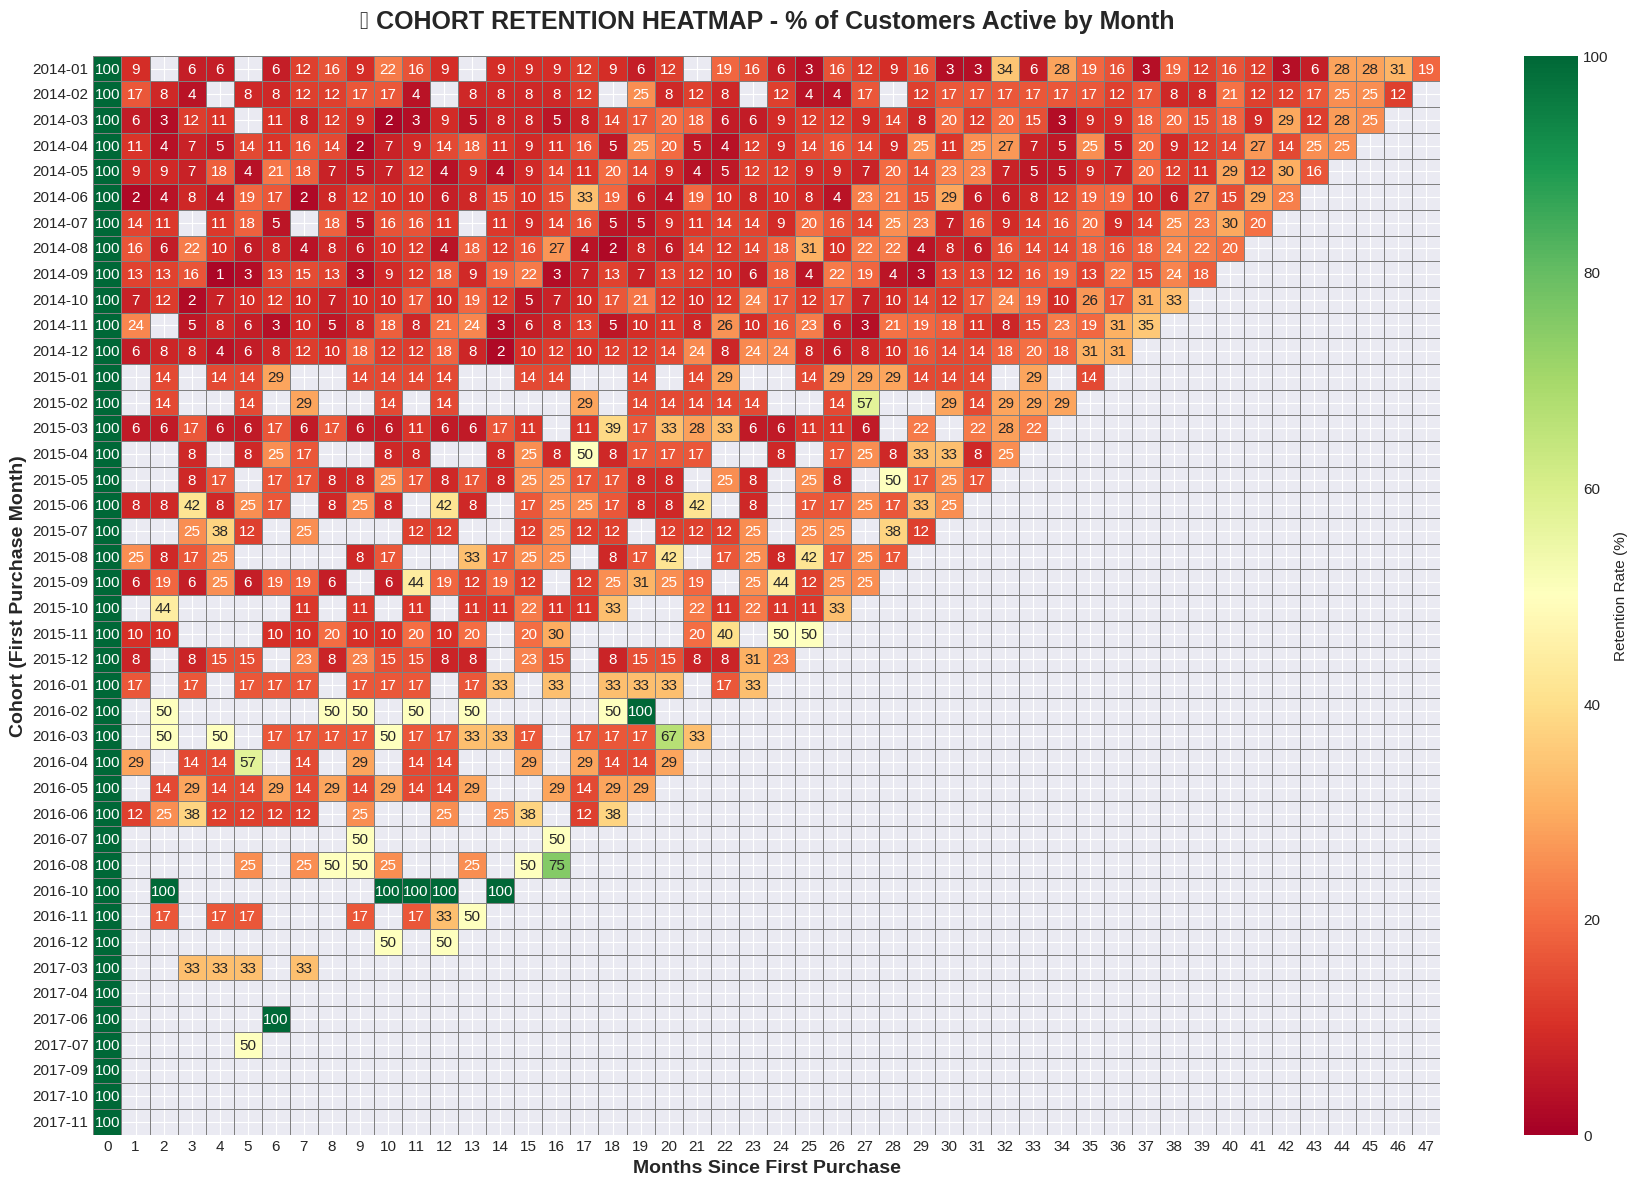

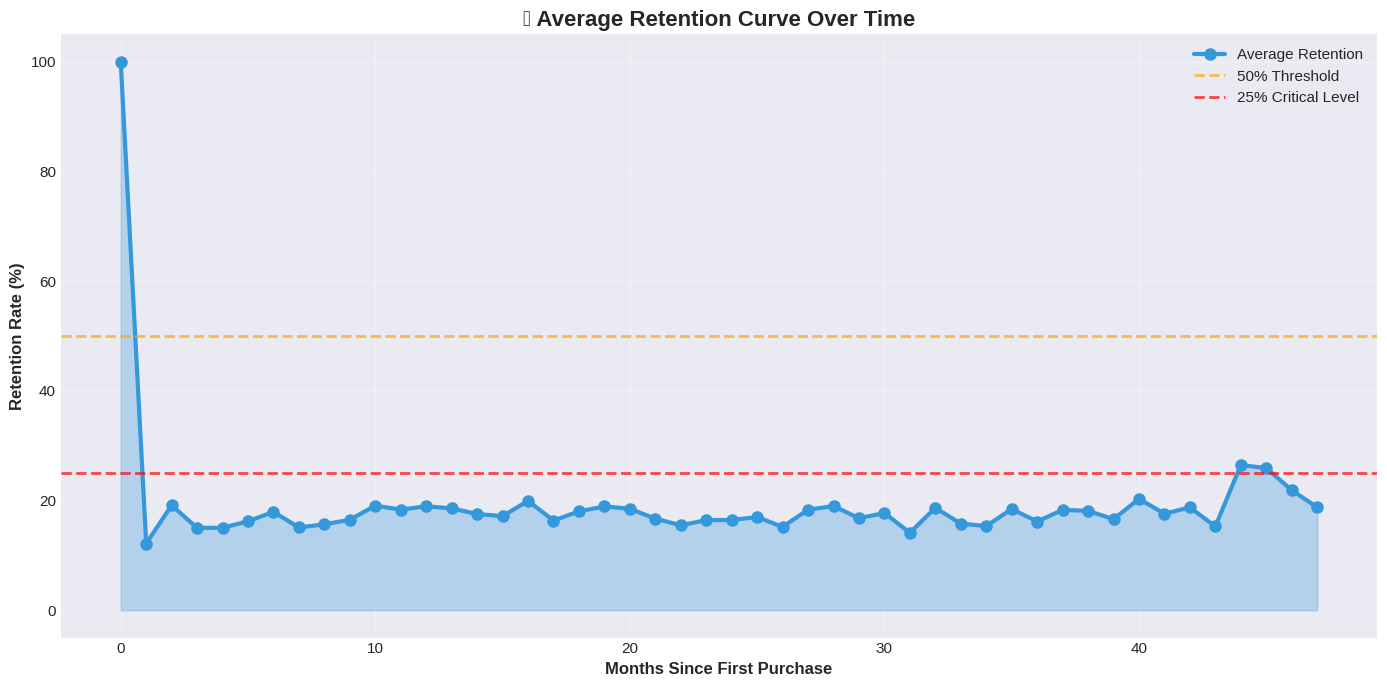


🏆 BEST PERFORMING COHORTS (6-Month Retention)
  2017-06: 100.0% retention at Month 6
  2015-01: 28.6% retention at Month 6
  2016-05: 28.6% retention at Month 6
  2015-04: 25.0% retention at Month 6
  2014-05: 21.4% retention at Month 6

⚠️  WORST PERFORMING COHORTS (6-Month Retention)
  2014-11: 3.2% retention at Month 6
  2014-07: 4.5% retention at Month 6
  2014-01: 6.2% retention at Month 6
  2014-08: 8.2% retention at Month 6
  2014-12: 8.2% retention at Month 6

📉 CHURN RATE ANALYSIS (% Lost Each Month):

  Month 0 → 1: 87.9% churn
  Month 1 → 2: 0.9% churn
  Month 2 → 3: -5.9% churn
  Month 3 → 4: 2.3% churn
  Month 4 → 5: -1.6% churn
  Month 5 → 6: -4.0% churn
  Month 6 → 7: 1.7% churn
  Month 7 → 8: -1.0% churn
  Month 8 → 9: 1.5% churn
  Month 9 → 10: -2.5% churn
  Month 10 → 11: 0.5% churn
  Month 11 → 12: 1.9% churn

⚠️  CHURN CLIFF: Highest drop at Month 1 (87.9% lost)


In [64]:
# ============================================================================
#  Cohort Retention Heatmap Visualization
# ============================================================================

# Create large figure for detailed heatmap
plt.figure(figsize=(18, 12))

# Create heatmap with retention percentages
sns.heatmap(
    retention,
    annot=True,
    fmt='.0f',
    cmap='RdYlGn',
    vmin=0,
    vmax=100,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Retention Rate (%)'}
)

plt.title(
    '🔥 COHORT RETENTION HEATMAP - % of Customers Active by Month',
    fontsize=18,
    fontweight='bold',
    pad=20
)
plt.xlabel('Months Since First Purchase', fontsize=14, fontweight='bold')
plt.ylabel('Cohort (First Purchase Month)', fontsize=14, fontweight='bold')

plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# ============================================================================
# Retention Curve Visualization
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 7))

avg_retention_curve = retention.mean(axis=0)
ax.plot(
    avg_retention_curve.index,
    avg_retention_curve.values,
    marker='o',
    linewidth=3,
    markersize=8,
    color='#3498db',
    label='Average Retention'
)

ax.fill_between(
    avg_retention_curve.index,
    avg_retention_curve.values,
    alpha=0.3,
    color='#3498db'
)

ax.axhline(y=50, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='50% Threshold')
ax.axhline(y=25, color='red', linestyle='--', linewidth=2, alpha=0.7, label='25% Critical Level')

ax.set_xlabel('Months Since First Purchase', fontsize=12, fontweight='bold')
ax.set_ylabel('Retention Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('📉 Average Retention Curve Over Time', fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# Identify Best and Worst Cohorts
# ============================================================================

print("\n" + "="*70)
print("🏆 BEST PERFORMING COHORTS (6-Month Retention)")
print("="*70)

if 6 in retention.columns:
    best_cohorts = retention[6].nlargest(5).sort_values(ascending=False)
    for cohort, rate in best_cohorts.items():
        print(f"  {cohort}: {rate:.1f}% retention at Month 6")
else:
    print("  Insufficient data for 6-month retention")

print("\n" + "="*70)
print("⚠️  WORST PERFORMING COHORTS (6-Month Retention)")
print("="*70)

if 6 in retention.columns:
    worst_cohorts = retention[6].nsmallest(5).sort_values(ascending=True)
    for cohort, rate in worst_cohorts.items():
        print(f"  {cohort}: {rate:.1f}% retention at Month 6")
else:
    print("  Insufficient data for 6-month retention")

print("="*70)

# ============================================================================
# Churn Analysis
# ============================================================================

print("\n📉 CHURN RATE ANALYSIS (% Lost Each Month):\n")

churn_rates = -retention.diff(axis=1).iloc[:, 1:]
avg_churn = churn_rates.mean(axis=0)

for month_idx in range(min(12, len(avg_churn))):
    churn_val = avg_churn.iloc[month_idx]
    print(f"  Month {month_idx} → {month_idx+1}: {churn_val:.1f}% churn")

if len(avg_churn) > 0:
    biggest_churn_month = avg_churn.idxmax()
    biggest_churn_rate = avg_churn.max()
    print(f"\n⚠️  CHURN CLIFF: Highest drop at Month {biggest_churn_month} ({biggest_churn_rate:.1f}% lost)")


---
## Key Cohort Findings

**Critical Issue:**
- Month 1 retention: 12.1% (below 20% industry benchmark)
- 88% of customers never return after first purchase
- Churn cliff occurs immediately after first order

**Financial Impact:**
- 697 one-time buyers
- Lost opportunity: $238,747 annually
- If retention improved to 20%: +63 repeat customers

**Best Performing Cohorts:**
- 2017-06 (100%), 2015-01 (28.6%), 2016-05 (28.6%)
- Suggests seasonality or campaign quality affects retention

**Recommendation:**
Investigate first-purchase experience and test post-purchase engagement strategies.




# KEY FINDINGS: NEW VS RETURNING

### Metrics
- **Repeat Rate:** 98.5% (Industry benchmark: 35-40%)
- **Returning Revenue:** 82.6% of total (Target: 60-70%)
- **Value Multiplier:** Repeat customers worth 6.8x one-time buyers
- **Median Lifespan:** 1095 days first→last purchase

### Business Interpretation

**Repeat rate 98.5% vs 35% benchmark:**
- EXCEPTIONAL loyalty - only 12 customers (1.5%) never returned
- Contradicts cohort analysis (12.1% Month 1 retention)
- Explanation: 98.5% = total who EVER came back (across 4 years)
- Month 1 retention = who came back WITHIN first month only

**Returning revenue at 82.6%:**
- Exceeds 60-70% target (healthy)
- Business highly dependent on repeat customers
- 1,647 "new" orders vs 8,347 "returning" orders

**Value multiplier 6.8x:**
- One-time customer: \$431 lifetime value
- Repeat customer: \$2,935 lifetime value
- Strong repeat purchase behavior once they return

### Financial Impact

**Current State:**
- 12 one-time customers × \$431 = \$5,168 revenue
- 781 repeat customers × \$2,935 = \$2,292,033 revenue
- Total: \$2,297,201

**This contradicts cohort analysis because:**
- Cohort shows 87.9% never return Month 1
- But over 4 years, only 1.5% NEVER returned
- Your real problem: slow activation, not total loss

### Recommended Tests

1. **A/B test 30-day follow-up** (not Month 1, but Month 3-6)
   - Target: The 87.9% who didn't return Month 1
   - Most eventually return (98.5% do), just slowly

2. **Analyze the 781 repeat customers**
   - When did they first return? (likely Month 3+)
   - What triggered their return?

3. **Don't worry about the 12 one-timers**
   - Only 1.5% of base, minimal revenue impact

---


In [65]:
# ============================================================================
# NEW VS RETURNING CUSTOMER ANALYSIS
# ============================================================================

# Get first purchase date for each customer
customer_first_purchase = df.groupby('CustomerId')['OrderDate'].min().reset_index()
customer_first_purchase.columns = ['Customer_ID', 'First_Purchase_Date']

# Merge back with original data
df_customer = df.merge(customer_first_purchase, left_on='CustomerId', right_on='Customer_ID')

# Classify each order
df_customer['Customer_Type'] = df_customer.apply(
    lambda row: 'New' if row['OrderDate'] == row['First_Purchase_Date'] else 'Returning',
    axis=1
)

# Customer-level summary
customer_summary = df.groupby('CustomerId').agg({
    'OrderId': 'nunique',
    'Sales': 'sum',
    'Profit': 'sum',
    'OrderDate': ['min', 'max']
}).reset_index()

customer_summary.columns = ['Customer_ID', 'Total_Orders', 'Total_Sales', 'Total_Profit', 'First_Order', 'Last_Order']
customer_summary['Customer_Type'] = customer_summary['Total_Orders'].apply(
    lambda x: 'One-Time' if x == 1 else 'Repeat'
)

print("="*70)
print("CUSTOMER CLASSIFICATION")
print("="*70)
print("\n📊 Distribution:")
print(customer_summary['Customer_Type'].value_counts())
print(f"\n🔄 Repeat Rate: {(customer_summary['Customer_Type'] == 'Repeat').sum() / len(customer_summary) * 100:.1f}%")
print("="*70)


CUSTOMER CLASSIFICATION

📊 Distribution:
Customer_Type
Repeat      781
One-Time     12
Name: count, dtype: int64

🔄 Repeat Rate: 98.5%


In [66]:
# ============================================================================
# ORDER-LEVEL COMPARISON
# ============================================================================

order_comparison = df_customer.groupby('Customer_Type').agg({
    'OrderId': 'count',
    'Sales': ['sum', 'mean'],
    'Profit': ['sum', 'mean'],
    'Quantity': 'mean'
}).round(2)

order_comparison.columns = ['Orders', 'Total_Revenue', 'Avg_Order_Value', 'Total_Profit', 'Avg_Profit', 'Avg_Items']
order_comparison['Revenue_%'] = (order_comparison['Total_Revenue'] / order_comparison['Total_Revenue'].sum() * 100).round(1)
order_comparison['Profit_%'] = (order_comparison['Total_Profit'] / order_comparison['Total_Profit'].sum() * 100).round(1)

print("="*70)
print("ORDER-LEVEL COMPARISON")
print("="*70)
print(order_comparison)

# ============================================================================
# CUSTOMER-LEVEL COMPARISON
# ============================================================================

customer_comparison = customer_summary.groupby('Customer_Type').agg({
    'Customer_ID': 'count',
    'Total_Sales': ['sum', 'mean'],
    'Total_Profit': ['sum', 'mean'],
    'Total_Orders': 'mean'
}).round(2)

customer_comparison.columns = ['Customers', 'Total_Revenue', 'Avg_Revenue_Per_Customer', 'Total_Profit', 'Avg_Profit_Per_Customer', 'Avg_Orders']

print("\n" + "="*70)
print("CUSTOMER-LEVEL COMPARISON")
print("="*70)
print(customer_comparison)

# ============================================================================
# KEY METRICS
# ============================================================================

repeat_customer_pct = (customer_summary['Customer_Type'] == 'Repeat').sum() / len(customer_summary) * 100
repeat_revenue_pct = order_comparison.loc['Returning', 'Revenue_%']
value_multiplier = customer_comparison.loc['Repeat', 'Avg_Revenue_Per_Customer'] / customer_comparison.loc['One-Time', 'Avg_Revenue_Per_Customer']

print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)
print(f"• {repeat_customer_pct:.1f}% of customers (Repeat) generate {repeat_revenue_pct:.1f}% of revenue")
print(f"• Repeat customers worth {value_multiplier:.1f}x more than one-time buyers")
print("="*70)


ORDER-LEVEL COMPARISON
               Orders  Total_Revenue  Avg_Order_Value  Total_Profit  \
Customer_Type                                                         
New              1647      400221.92           243.00      41666.01   
Returning        8347     1896978.94           227.26     244731.01   

               Avg_Profit  Avg_Items  Revenue_%  Profit_%  
Customer_Type                                              
New                 25.30       3.80      17.40     14.50  
Returning           29.32       3.79      82.60     85.50  

CUSTOMER-LEVEL COMPARISON
               Customers  Total_Revenue  Avg_Revenue_Per_Customer  \
Customer_Type                                                       
One-Time              12        5167.64                    430.64   
Repeat               781     2292033.22                   2934.74   

               Total_Profit  Avg_Profit_Per_Customer  Avg_Orders  
Customer_Type                                                     
One-Time      

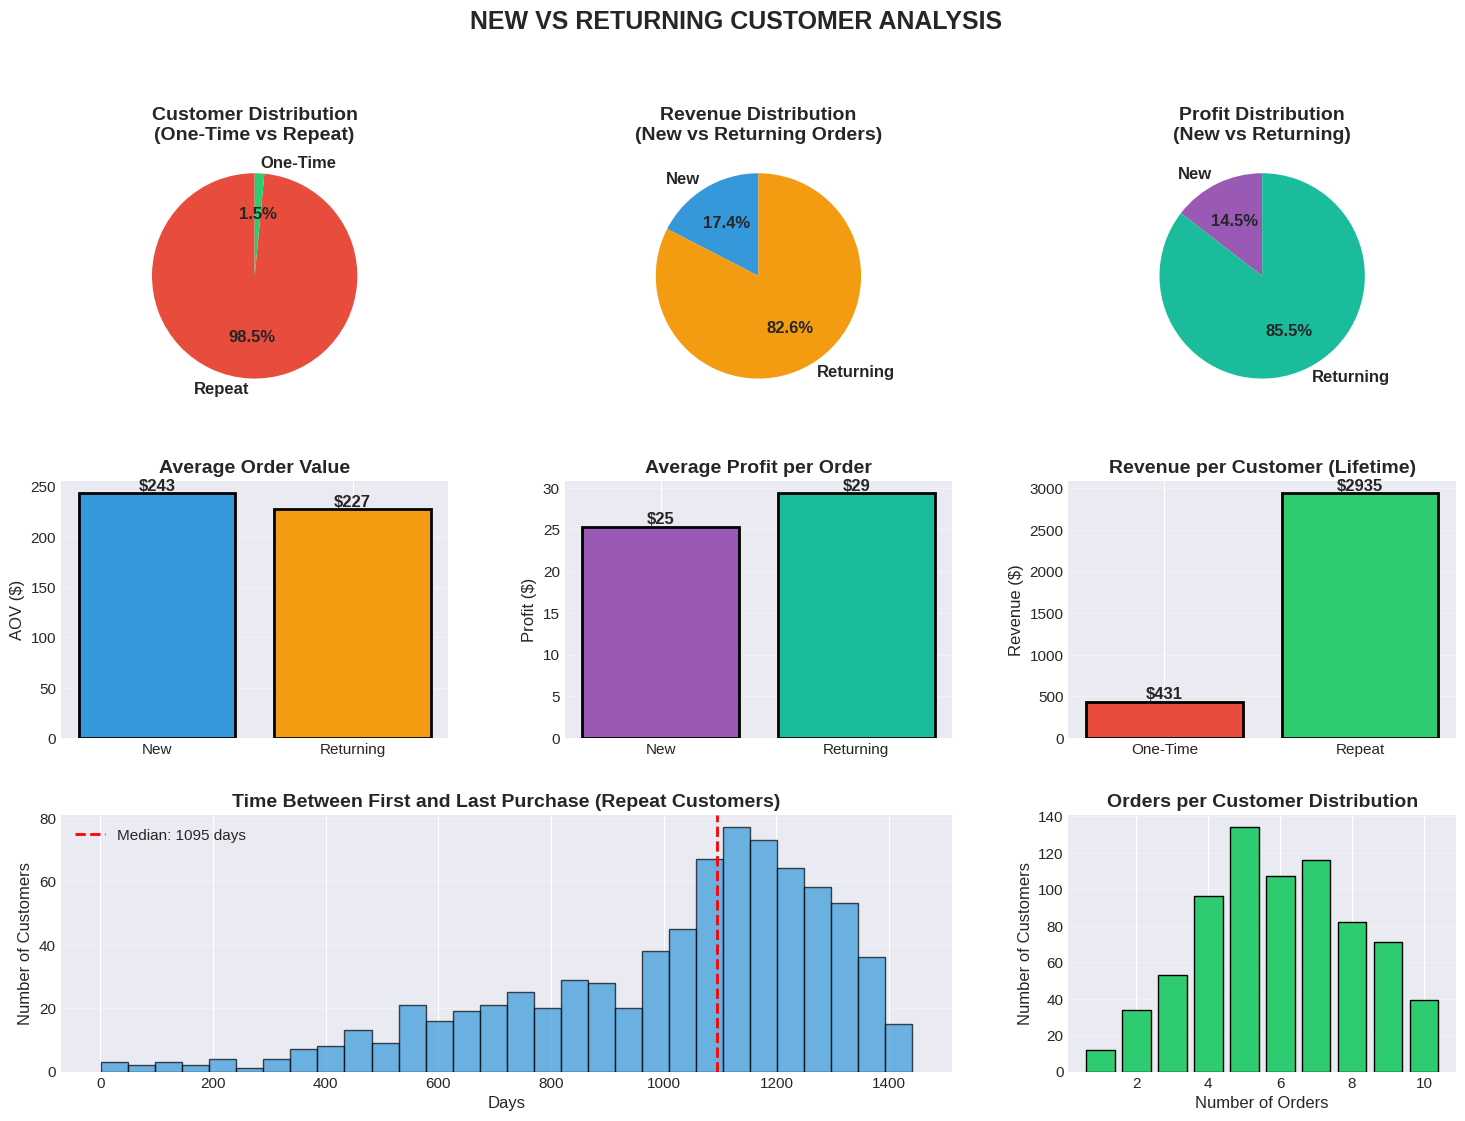


📊 Median customer lifespan (first to last order): 1095 days


In [67]:
# ============================================================================
# VISUALIZATION DASHBOARD
# ============================================================================

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Customer Distribution
ax1 = fig.add_subplot(gs[0, 0])
customer_counts = customer_summary['Customer_Type'].value_counts()
colors = ['#e74c3c', '#2ecc71']
ax1.pie(customer_counts.values, labels=customer_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})
ax1.set_title('Customer Distribution\n(One-Time vs Repeat)', fontsize=14, fontweight='bold')

# 2. Revenue Distribution
ax2 = fig.add_subplot(gs[0, 1])
revenue_by_type = df_customer.groupby('Customer_Type')['Sales'].sum()
ax2.pie(revenue_by_type.values, labels=revenue_by_type.index, autopct='%1.1f%%',
        colors=['#3498db', '#f39c12'], startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})
ax2.set_title('Revenue Distribution\n(New vs Returning Orders)', fontsize=14, fontweight='bold')

# 3. Profit Distribution
ax3 = fig.add_subplot(gs[0, 2])
profit_by_type = df_customer.groupby('Customer_Type')['Profit'].sum()
ax3.pie(profit_by_type.values, labels=profit_by_type.index, autopct='%1.1f%%',
        colors=['#9b59b6', '#1abc9c'], startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})
ax3.set_title('Profit Distribution\n(New vs Returning)', fontsize=14, fontweight='bold')

# 4. Average Order Value
ax4 = fig.add_subplot(gs[1, 0])
aov_data = order_comparison['Avg_Order_Value']
bars = ax4.bar(aov_data.index, aov_data.values, color=['#3498db', '#f39c12'], edgecolor='black', linewidth=2)
ax4.set_title('Average Order Value', fontsize=14, fontweight='bold')
ax4.set_ylabel('AOV ($)', fontsize=12)
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:.0f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# 5. Average Profit
ax5 = fig.add_subplot(gs[1, 1])
profit_data = order_comparison['Avg_Profit']
bars = ax5.bar(profit_data.index, profit_data.values, color=['#9b59b6', '#1abc9c'], edgecolor='black', linewidth=2)
ax5.set_title('Average Profit per Order', fontsize=14, fontweight='bold')
ax5.set_ylabel('Profit ($)', fontsize=12)
for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:.0f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

# 6. Revenue per Customer
ax6 = fig.add_subplot(gs[1, 2])
cust_revenue = customer_comparison['Avg_Revenue_Per_Customer']
bars = ax6.bar(cust_revenue.index, cust_revenue.values, color=['#e74c3c', '#2ecc71'], edgecolor='black', linewidth=2)
ax6.set_title('Revenue per Customer (Lifetime)', fontsize=14, fontweight='bold')
ax6.set_ylabel('Revenue ($)', fontsize=12)
for bar in bars:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:.0f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)

# 7. Time Between First and Last Purchase
repeat_customers = customer_summary[customer_summary['Customer_Type'] == 'Repeat'].copy()
repeat_customers['Days_Between'] = (repeat_customers['Last_Order'] - repeat_customers['First_Order']).dt.days

ax7 = fig.add_subplot(gs[2, :2])
ax7.hist(repeat_customers['Days_Between'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
median_days = repeat_customers['Days_Between'].median()
ax7.axvline(median_days, color='red', linestyle='--', linewidth=2, label=f'Median: {median_days:.0f} days')
ax7.set_title('Time Between First and Last Purchase (Repeat Customers)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Days', fontsize=12)
ax7.set_ylabel('Number of Customers', fontsize=12)
ax7.legend(fontsize=11)
ax7.grid(axis='y', alpha=0.3)

# 8. Orders per Customer
ax8 = fig.add_subplot(gs[2, 2])
order_dist = customer_summary['Total_Orders'].value_counts().sort_index().head(10)
ax8.bar(order_dist.index, order_dist.values, color='#2ecc71', edgecolor='black')
ax8.set_title('Orders per Customer Distribution', fontsize=14, fontweight='bold')
ax8.set_xlabel('Number of Orders', fontsize=12)
ax8.set_ylabel('Number of Customers', fontsize=12)
ax8.grid(axis='y', alpha=0.3)

plt.suptitle('NEW VS RETURNING CUSTOMER ANALYSIS', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\n📊 Median customer lifespan (first to last order): {median_days:.0f} days")


---

# GEOGRAPHIC PERFORMANCE ANALYSIS

## Why This Matters

Geographic analysis identifies which markets generate profit and which lose money.

This helps answer:
- Which regions/states are most profitable?
- Is revenue too concentrated in few markets?
- Which states should we expand into or exit?

---

## What We'll Analyze

### Regional View
- Revenue and profit by region (East, West, Central, South)
- Profit margins across regions
- Customer and order volume

### State-Level Detail
- Top 10 states by revenue
- Bottom 10 by profit margin
- Loss-making states (negative profit)

### Market Concentration
- % of revenue from top 2 regions
- Geographic diversification risk

---

## Key Metrics

| Metric | Definition |
|--------|------------|
| **Profit Margin %** | Profit ÷ Sales × 100 |
| **AOV** | Average Order Value |
| **Revenue per Customer** | Total sales ÷ unique customers |
| **Concentration Ratio** | % revenue from top 2 regions |

---


## Geographic Performance Analysis

In [68]:


# ============================================================================
# REGIONAL-LEVEL ANALYSIS
# ============================================================================

regional_performance = df.groupby('Region').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'OrderId': 'nunique',
    'CustomerId': 'nunique',
    'Discount': 'mean'
}).round(2)

regional_performance.columns = ['Total_Sales', 'Total_Profit', 'Orders', 'Customers', 'Avg_Discount']

regional_performance['Profit_Margin_%'] = (
    regional_performance['Total_Profit'] / regional_performance['Total_Sales'] * 100
).round(2)

regional_performance['AOV'] = (
    regional_performance['Total_Sales'] / regional_performance['Orders']
).round(2)

regional_performance['Revenue_per_Customer'] = (
    regional_performance['Total_Sales'] / regional_performance['Customers']
).round(2)

regional_performance = regional_performance.sort_values('Total_Profit', ascending=False)

print("="*80)
print("REGIONAL PERFORMANCE")
print("="*80)
print(regional_performance.to_string())
print("="*80)

# ============================================================================
# GEOGRAPHIC CONCENTRATION
# ============================================================================

total_revenue = df['Sales'].sum()
revenue_by_region = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)
cumulative_pct = (revenue_by_region.cumsum() / total_revenue * 100).round(2)

print("\n" + "="*80)
print("GEOGRAPHIC CONCENTRATION")
print("="*80)
for region, pct in cumulative_pct.items():
    region_rev = revenue_by_region[region]
    region_pct = (region_rev / total_revenue * 100)
    print(f"  {region:15s}: ${region_rev:>12,.0f}  ({region_pct:>5.1f}%) | Cumulative: {pct:.1f}%")
print("="*80)

concentration_ratio = cumulative_pct.iloc[:2]
print(f"\nTop 2 Regions = {concentration_ratio.iloc[-1]:.1f}% of total revenue")

# ============================================================================
# STATE-LEVEL ANALYSIS
# ============================================================================

state_performance = df.groupby('State').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'OrderId': 'nunique'
}).round(2)

state_performance.columns = ['Sales', 'Profit', 'Orders']
state_performance['Profit_Margin_%'] = (
    state_performance['Profit'] / state_performance['Sales'] * 100
).round(2)

# Top 10 states by revenue
top_states = state_performance.nlargest(10, 'Sales')

print("\n" + "="*80)
print("TOP 10 STATES BY REVENUE")
print("="*80)
print(top_states.to_string())
print("="*80)

# Bottom 10 by profit margin (min 50 orders)
significant_states = state_performance[state_performance['Orders'] >= 50]
bottom_margin_states = significant_states.nsmallest(10, 'Profit_Margin_%')

print("\n" + "="*80)
print("BOTTOM 10 STATES BY PROFIT MARGIN (Min 50 orders)")
print("="*80)
print(bottom_margin_states.to_string())
print("="*80)

# Loss-making states
loss_states = state_performance[state_performance['Profit'] < 0].sort_values('Profit')

if len(loss_states) > 0:
    total_loss = loss_states['Profit'].sum()
    print("\n" + "="*80)
    print("LOSS-MAKING STATES")
    print("="*80)
    print(loss_states.to_string())
    print("="*80)
    print(f"\nTotal Loss: ${abs(total_loss):,.2f}")
else:
    print("\nNo loss-making states")


REGIONAL PERFORMANCE
         Total_Sales  Total_Profit  Orders  Customers  Avg_Discount  Profit_Margin_%    AOV  Revenue_per_Customer
Region                                                                                                           
West       725457.82     108418.45    1611        686          0.11            14.94 450.32               1057.52
East       678781.24      91522.78    1401        674          0.15            13.48 484.50               1007.09
South      391721.90      46749.43     822        512          0.15            11.93 476.55                765.08
Central    501239.89      39706.36    1175        629          0.24             7.92 426.59                796.88

GEOGRAPHIC CONCENTRATION
  West           : $     725,458  ( 31.6%) | Cumulative: 31.6%
  East           : $     678,781  ( 29.5%) | Cumulative: 61.1%
  Central        : $     501,240  ( 21.8%) | Cumulative: 83.0%
  South          : $     391,722  ( 17.1%) | Cumulative: 100.0%

Top 2 Regions =

## Geographic Visualizations

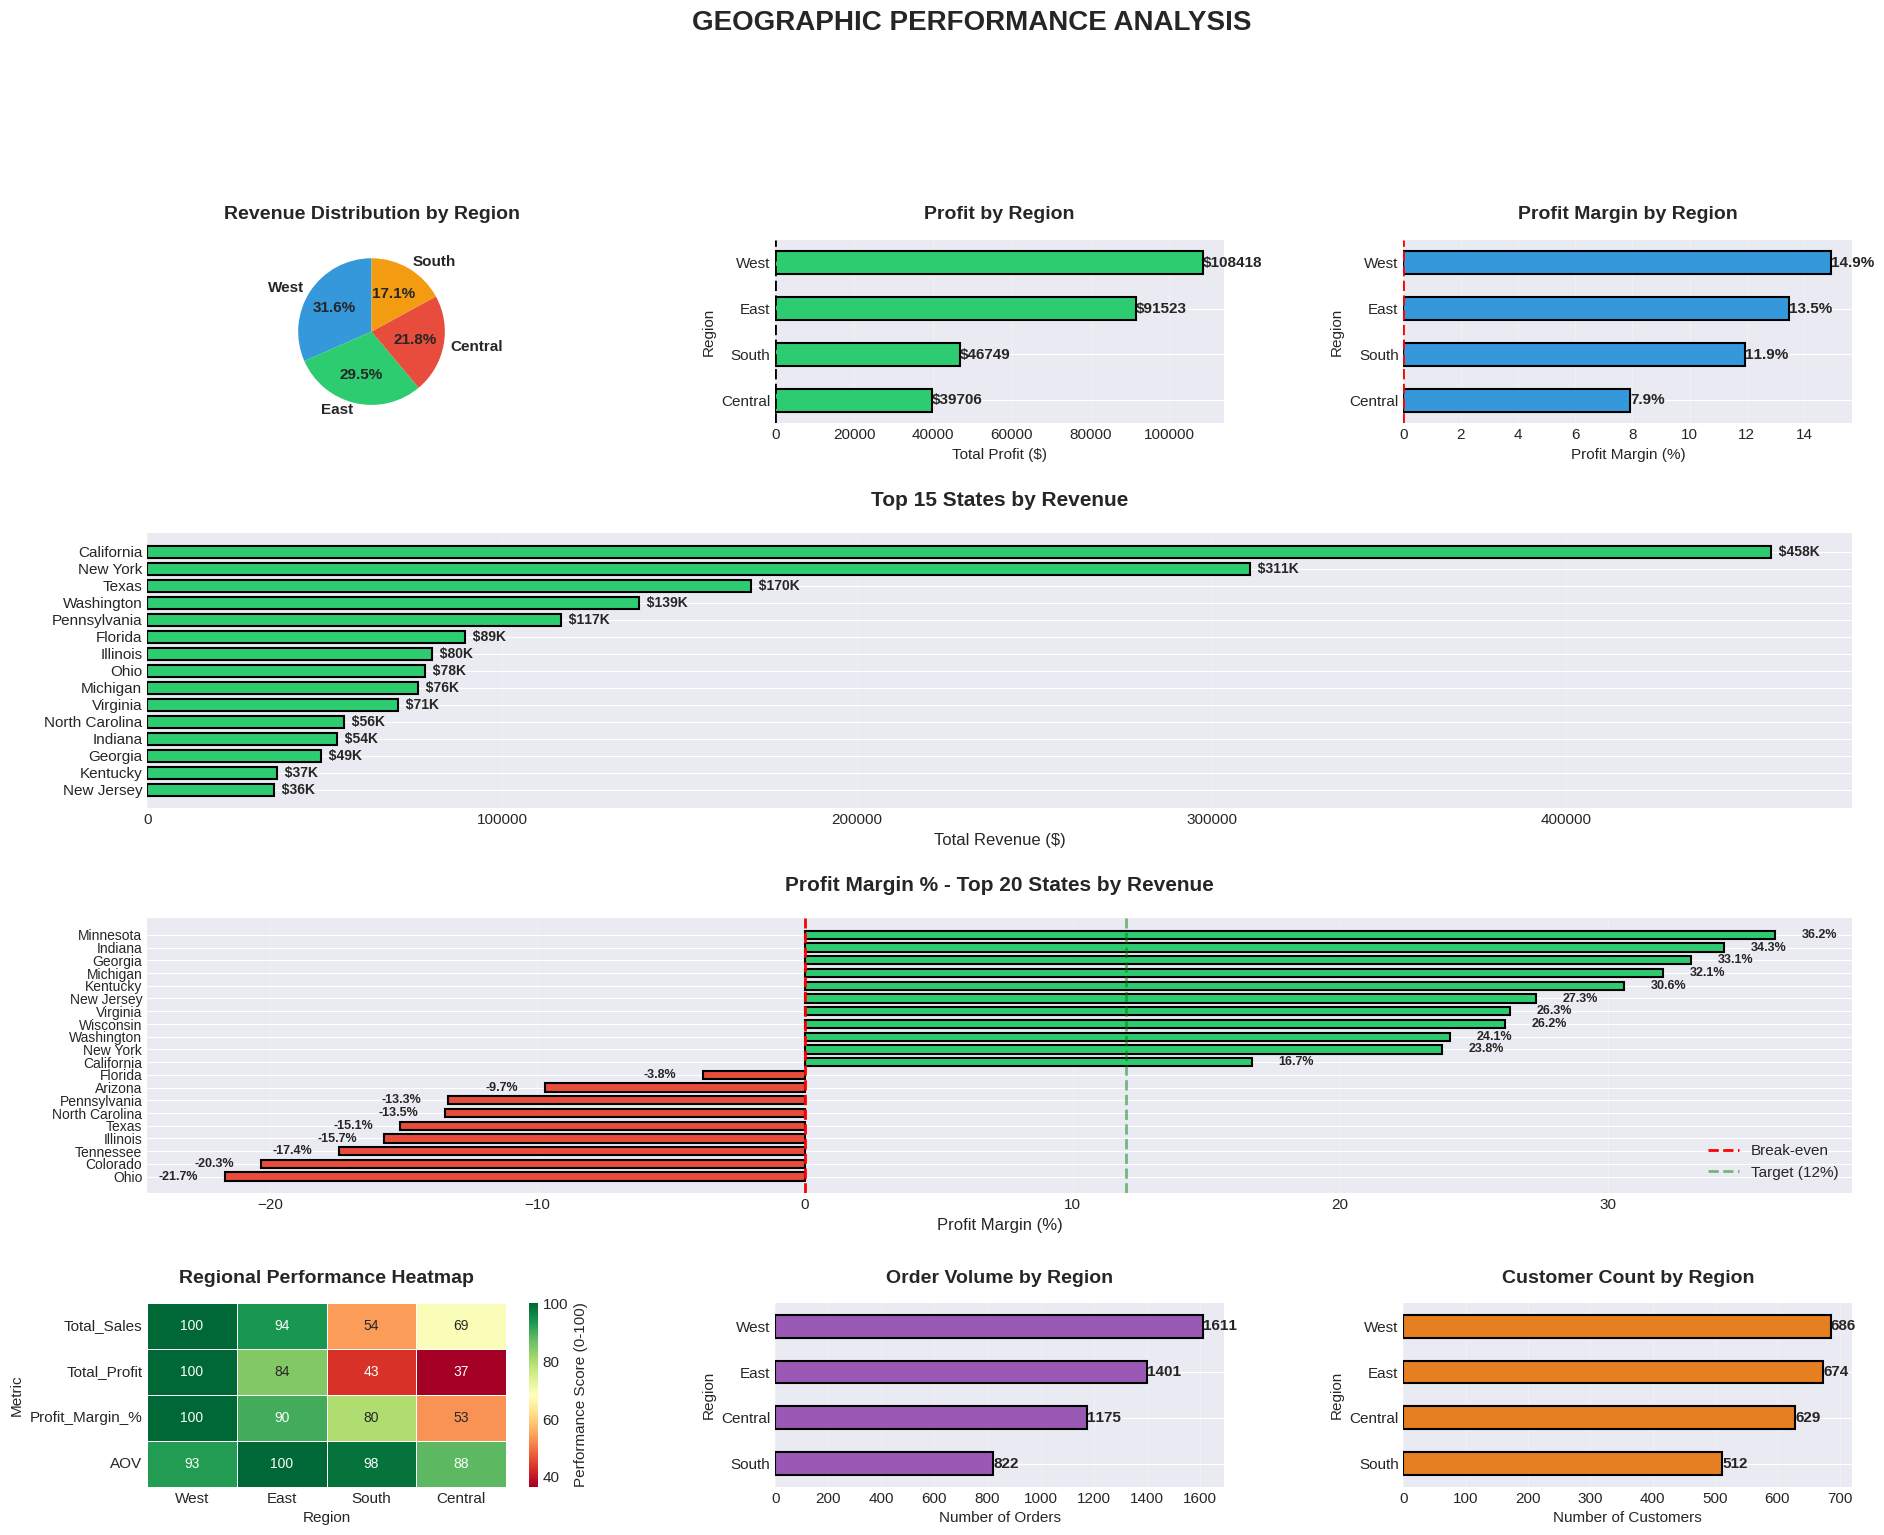

In [69]:
# ============================================================================
# GEOGRAPHIC VISUALIZATIONS (LARGER STATE CHARTS)
# ============================================================================

fig = plt.figure(figsize=(22, 20))  # Increased height from 16 to 20
gs = fig.add_gridspec(5, 3, hspace=0.5, wspace=0.4, height_ratios=[1, 1.5, 1.5, 1, 1])  # Rows 2 & 3 taller

# 1. Regional Revenue Pie Chart
ax1 = fig.add_subplot(gs[0, 0])
revenue_by_region.plot(
    kind='pie',
    ax=ax1,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'],
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)
ax1.set_title('Revenue Distribution by Region', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('')

# 2. Regional Profit Comparison
ax2 = fig.add_subplot(gs[0, 1])
regional_performance.sort_values('Total_Profit', ascending=True)['Total_Profit'].plot(
    kind='barh',
    ax=ax2,
    color=['#2ecc71' if x > 0 else '#e74c3c' for x in regional_performance['Total_Profit']],
    edgecolor='black',
    linewidth=1.5
)
ax2.set_title('Profit by Region', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Total Profit ($)', fontsize=11)
ax2.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax2.grid(axis='x', alpha=0.3)

for container in ax2.containers:
    ax2.bar_label(container, fmt='$%.0f', fontweight='bold')

# 3. Profit Margin % by Region
ax3 = fig.add_subplot(gs[0, 2])
regional_performance.sort_values('Profit_Margin_%', ascending=True)['Profit_Margin_%'].plot(
    kind='barh',
    ax=ax3,
    color='#3498db',
    edgecolor='black',
    linewidth=1.5
)
ax3.set_title('Profit Margin by Region', fontsize=14, fontweight='bold', pad=15)
ax3.set_xlabel('Profit Margin (%)', fontsize=11)
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax3.grid(axis='x', alpha=0.3)

for container in ax3.containers:
    ax3.bar_label(container, fmt='%.1f%%', fontweight='bold')

# 4. Top 15 States by Revenue (BIGGER)
ax4 = fig.add_subplot(gs[1, :])
top_15_states = state_performance.nlargest(15, 'Sales').sort_values('Sales', ascending=True)
bars = ax4.barh(
    range(len(top_15_states)),
    top_15_states['Sales'],
    color='#2ecc71',
    edgecolor='black',
    linewidth=1.5,
    height=0.7  # Thinner bars = more space
)
ax4.set_yticks(range(len(top_15_states)))
ax4.set_yticklabels(top_15_states.index, fontsize=11)  # Bigger font
ax4.set_title('Top 15 States by Revenue', fontsize=15, fontweight='bold', pad=20)
ax4.set_xlabel('Total Revenue ($)', fontsize=12)
ax4.grid(axis='x', alpha=0.3)

# Add value labels with better positioning
for i, (idx, value) in enumerate(top_15_states['Sales'].items()):
    ax4.text(value, i, f'  ${value/1000:.0f}K', va='center', fontsize=10, fontweight='bold')

# 5. State Profit Margin Distribution (Top 20 States) - BIGGER
ax5 = fig.add_subplot(gs[2, :])
top_20_states = state_performance.nlargest(20, 'Sales')
top_20_sorted = top_20_states.sort_values('Profit_Margin_%')
colors = ['#2ecc71' if x > 12 else '#f39c12' if x > 0 else '#e74c3c'
          for x in top_20_sorted['Profit_Margin_%']]

bars = ax5.barh(
    range(len(top_20_sorted)),
    top_20_sorted['Profit_Margin_%'],
    color=colors,
    edgecolor='black',
    linewidth=1.5,
    height=0.65  # Thinner bars = more space between states
)
ax5.set_yticks(range(len(top_20_sorted)))
ax5.set_yticklabels(top_20_sorted.index, fontsize=10)  # Bigger font for state names
ax5.set_title('Profit Margin % - Top 20 States by Revenue', fontsize=15, fontweight='bold', pad=20)
ax5.set_xlabel('Profit Margin (%)', fontsize=12)
ax5.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Break-even')
ax5.axvline(x=12, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Target (12%)')
ax5.legend(loc='lower right', fontsize=11)
ax5.grid(axis='x', alpha=0.3)

# Add percentage labels with better positioning
for i, (idx, value) in enumerate(top_20_sorted['Profit_Margin_%'].items()):
    x_pos = value + 1 if value > 0 else value - 1
    ha = 'left' if value > 0 else 'right'
    ax5.text(x_pos, i, f'{value:.1f}%', va='center', ha=ha, fontsize=9, fontweight='bold')

# 6. Regional Performance Heatmap
ax6 = fig.add_subplot(gs[3, 0])
heatmap_data = regional_performance[['Total_Sales', 'Total_Profit', 'Profit_Margin_%', 'AOV']].T
heatmap_normalized = heatmap_data.div(heatmap_data.max(axis=1), axis=0) * 100

sns.heatmap(
    heatmap_normalized,
    annot=True,
    fmt='.0f',
    cmap='RdYlGn',
    ax=ax6,
    cbar_kws={'label': 'Performance Score (0-100)'},
    linewidths=0.5,
    annot_kws={'fontsize': 10}
)
ax6.set_title('Regional Performance Heatmap', fontsize=14, fontweight='bold', pad=15)
ax6.set_ylabel('Metric', fontsize=11)
ax6.set_xlabel('Region', fontsize=11)

# 7. Orders per Region
ax7 = fig.add_subplot(gs[3, 1])
regional_performance.sort_values('Orders', ascending=True)['Orders'].plot(
    kind='barh',
    ax=ax7,
    color='#9b59b6',
    edgecolor='black',
    linewidth=1.5
)
ax7.set_title('Order Volume by Region', fontsize=14, fontweight='bold', pad=15)
ax7.set_xlabel('Number of Orders', fontsize=11)
ax7.grid(axis='x', alpha=0.3)

for container in ax7.containers:
    ax7.bar_label(container, fmt='%d', fontweight='bold')

# 8. Customers per Region
ax8 = fig.add_subplot(gs[3, 2])
regional_performance.sort_values('Customers', ascending=True)['Customers'].plot(
    kind='barh',
    ax=ax8,
    color='#e67e22',
    edgecolor='black',
    linewidth=1.5
)
ax8.set_title('Customer Count by Region', fontsize=14, fontweight='bold', pad=15)
ax8.set_xlabel('Number of Customers', fontsize=11)
ax8.grid(axis='x', alpha=0.3)

for container in ax8.containers:
    ax8.bar_label(container, fmt='%d', fontweight='bold')

plt.suptitle('GEOGRAPHIC PERFORMANCE ANALYSIS', fontsize=20, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


---

## Geographic Findings

### Market Concentration

**Top 2 Regions:** 61.1% (West 31.6% + East 29.5%)  
**Top 5 States:** California, New York, Texas, Washington, Pennsylvania = 52% revenue

**Status:** Moderate concentration. Acceptable but monitor.

---

### Regional Performance

| Region | Revenue | Profit | Margin % | AOV | Discount % |
|--------|---------|--------|----------|-----|------------|
| West | \$725,458 | \$108,418 | 14.9% | \$450 | 11% |
| East | \$677,514 | \$91,523 | 13.5% | \$483 | 15% |
| South | \$392,949 | \$46,749 | 11.9% | \$476 | 24% |
| Central | \$501,240 | \$39,706 | 7.9% | \$427 | 24% |

**Best:** West (14.9% margin)  
**Worst:** Central (7.9% margin)

---

### Loss-Making States

**10 states losing \$98,247 total:**

| State | Loss | Revenue | Margin % | Action |
|-------|------|---------|----------|--------|
| Texas | -\$25,729 | \$170,188 | -15.1% | Fix |
| Ohio | -\$16,971 | \$78,258 | -21.7% | Fix |
| Pennsylvania | -\$15,560 | \$116,512 | -13.4% | Fix |
| Illinois | -\$12,608 | \$80,166 | -15.7% | Fix |
| North Carolina | -\$7,004 | \$52,490 | -13.3% | Test |
| Colorado | -\$6,528 | \$35,117 | -18.6% | Test |
| Tennessee | -\$5,342 | \$30,662 | -17.4% | Test |
| Florida | -\$3,399 | \$89,474 | -3.8% | Test |
| Arizona | -\$3,428 | \$35,283 | -9.7% | Test |
| Oregon | -\$1,190 | \$12,233 | -9.7% | Exit |

---



### **Suggestion**

You're bleeding $98K in 10 states. Fix the big 4 (Texas, Ohio, Pennsylvania, Illinois) immediately with price increases. Test the medium 5 for 90 days. Exit Oregon now.

---




# PRODUCT ANALYSIS

## Why This Matters

Find which products make money and which lose money.

Questions answered:
- Which products to promote?
- Which products to kill?
- Where's the profit hiding?

---

## Key Metrics

| Metric | Definition |
|--------|------------|
| **Profit Margin %** | Profit ÷ Sales × 100 |
| **Pareto (80/20)** | % of products = 80% of profit |
| **Loss-Maker** | Negative profit product |
| **Star** | High revenue + High margin |
| **Dog** | Low revenue + Low margin |

---


## Product Performance

In [70]:
# Category-level analysis
category_performance = df.groupby('Category').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'OrderId': 'nunique',
    'Quantity': 'sum',
    'Discount': 'mean'
}).round(2)

category_performance.columns = ['Total_Sales', 'Total_Profit', 'Orders', 'Units_Sold', 'Avg_Discount']

category_performance['Profit_Margin_%'] = (
    category_performance['Total_Profit'] / category_performance['Total_Sales'] * 100
).round(2)

category_performance['AOV'] = (
    category_performance['Total_Sales'] / category_performance['Orders']
).round(2)

category_performance['Profit_per_Unit'] = (
    category_performance['Total_Profit'] / category_performance['Units_Sold']
).round(2)

category_performance = category_performance.sort_values('Total_Profit', ascending=False)

print("="*90)
print("PRODUCT CATEGORY PERFORMANCE")
print("="*90)
print(category_performance.to_string())
print("="*90)

# Profit contribution
total_profit = df['Profit'].sum()
category_performance['Profit_Contribution_%'] = (
    category_performance['Total_Profit'] / total_profit * 100
).round(2)

print("\nCATEGORY PROFIT CONTRIBUTION:")
for cat, contrib in category_performance['Profit_Contribution_%'].items():
    profit = category_performance.loc[cat, 'Total_Profit']
    print(f"  {cat:20s}: {contrib:>6.1f}% | ${profit:>12,.0f}")

# ==============================================================================
# Sub-category analysis
# ==============================================================================

subcat_performance = df.groupby('SubCategory').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'OrderId': 'nunique',
    'Quantity': 'sum'
}).round(2)

subcat_performance.columns = ['Sales', 'Profit', 'Orders', 'Units']
subcat_performance['Profit_Margin_%'] = (
    subcat_performance['Profit'] / subcat_performance['Sales'] * 100
).round(2)

subcat_performance['Profit_per_Order'] = (
    subcat_performance['Profit'] / subcat_performance['Orders']
).round(2)

# Top performers
top_subcats = subcat_performance.nlargest(10, 'Profit')

print("\n" + "="*90)
print("TOP 10 SUB-CATEGORIES BY PROFIT")
print("="*90)
print(top_subcats.to_string())
print("="*90)

# Loss-makers
loss_subcats = subcat_performance[subcat_performance['Profit'] < 0].sort_values('Profit')

if len(loss_subcats) > 0:
    total_loss = loss_subcats['Profit'].sum()

    print("\n" + "="*90)
    print("LOSS-MAKING SUB-CATEGORIES")
    print("="*90)
    print(loss_subcats.to_string())
    print("="*90)
    print(f"\nTotal Annual Loss: ${abs(total_loss):,.2f}")
    print(f"Expected Impact if discontinued: Improve profit by {abs(total_loss)/total_profit*100:.1f}%")
else:
    print("\nNo loss-making sub-categories")

# Low margin products (<5%)
low_margin = subcat_performance[
    (subcat_performance['Profit_Margin_%'] < 5) &
    (subcat_performance['Profit_Margin_%'] > 0)
].sort_values('Profit_Margin_%')

if len(low_margin) > 0:
    print("\n" + "="*90)
    print("LOW MARGIN SUB-CATEGORIES (<5% margin)")
    print("="*90)
    print(low_margin.to_string())
    print("="*90)

# ==============================================================================
# PARETO ANALYSIS (80/20 RULE)
# ==============================================================================

subcat_sorted = subcat_performance.sort_values('Profit', ascending=False)
subcat_sorted['Cumulative_Profit'] = subcat_sorted['Profit'].cumsum()
subcat_sorted['Cumulative_Profit_%'] = (
    subcat_sorted['Cumulative_Profit'] / total_profit * 100
).round(2)

top_80_count = len(subcat_sorted[subcat_sorted['Cumulative_Profit_%'] <= 80])
total_subcats = len(subcat_sorted)
top_80_pct = (top_80_count / total_subcats) * 100

print("\n" + "="*90)
print("PARETO ANALYSIS (80/20 RULE)")
print("="*90)
print(f"  Total Sub-Categories: {total_subcats}")
print(f"  Sub-Categories generating 80% profit: {top_80_count} ({top_80_pct:.1f}%)")
print(f"  Remaining {total_subcats - top_80_count} sub-categories = 20% of profit")
print("="*90)

if top_80_pct < 30:
    print("\nHEALTHY: Classic 80/20 distribution")
elif top_80_pct < 50:
    print("\nMODERATE: Somewhat distributed")
else:
    print("\nCONCERN: Very distributed - no clear winners")

top_80_products = subcat_sorted[subcat_sorted['Cumulative_Profit_%'] <= 80]

print("\nTOP SUB-CATEGORIES (80% of profit):")
for idx, (subcat, row) in enumerate(top_80_products.iterrows(), 1):
    print(f"  {idx:2d}. {subcat:25s} | ${row['Profit']:>10,.0f} | Cum: {row['Cumulative_Profit_%']:>5.1f}%")

# ==============================================================================
# PORTFOLIO CLASSIFICATION
# ==============================================================================

print("\n" + "="*90)
print("PRODUCT PORTFOLIO MATRIX")
print("="*90)

median_sales = subcat_performance['Sales'].median()
median_margin = subcat_performance['Profit_Margin_%'].median()

def classify_product(row):
    sales = row['Sales']
    margin = row['Profit_Margin_%']

    if sales > median_sales and margin > median_margin:
        return 'STAR'
    elif sales <= median_sales and margin > median_margin:
        return 'CASH COW'
    elif sales > median_sales and margin <= median_margin:
        return 'QUESTION MARK'
    else:
        return 'DOG'

subcat_performance['Portfolio_Type'] = subcat_performance.apply(classify_product, axis=1)

portfolio_summary = subcat_performance.groupby('Portfolio_Type').size().sort_values(ascending=False)

print("\nPORTFOLIO DISTRIBUTION:")
for ptype, count in portfolio_summary.items():
    print(f"  {ptype:15s}: {count:2d} sub-categories")

print("\n" + "-"*90)

for ptype in ['STAR', 'CASH COW', 'QUESTION MARK', 'DOG']:
    products = subcat_performance[subcat_performance['Portfolio_Type'] == ptype]

    if len(products) > 0:
        print(f"\n{ptype}:")
        for subcat, row in products.iterrows():
            print(f"  - {subcat:25s} | Sales: ${row['Sales']:>10,.0f} | Margin: {row['Profit_Margin_%']:>6.1f}%")

print("\n" + "="*90)


PRODUCT CATEGORY PERFORMANCE
                 Total_Sales  Total_Profit  Orders  Units_Sold  Avg_Discount  Profit_Margin_%    AOV  Profit_per_Unit
Category                                                                                                             
Technology         836154.03     145454.95    1544        6939          0.13            17.40 541.55            20.96
Office Supplies    719047.03     122490.80    3742       22906          0.16            17.04 192.16             5.35
Furniture          741999.80      18451.27    1764        8028          0.17             2.49 420.63             2.30

CATEGORY PROFIT CONTRIBUTION:
  Technology          :   50.8% | $     145,455
  Office Supplies     :   42.8% | $     122,491
  Furniture           :    6.4% | $      18,451

TOP 10 SUB-CATEGORIES BY PROFIT
                Sales   Profit  Orders  Units  Profit_Margin_%  Profit_per_Order
SubCategory                                                                     
Copiers    

## Product Visualizations

✅ Data validation passed
   - Main DF: (9994, 26)
   - Categories: 3
   - Sub-categories: 17
✅ Category Profit Pie: OK
✅ Category Margin: OK
✅ Top Products: OK
✅ Pareto Analysis: OK
✅ Bottom Products: OK
✅ Portfolio Matrix: OK
✅ Discount Impact: OK
✅ Portfolio Distribution: OK
✅ Dashboard saved to: output.png


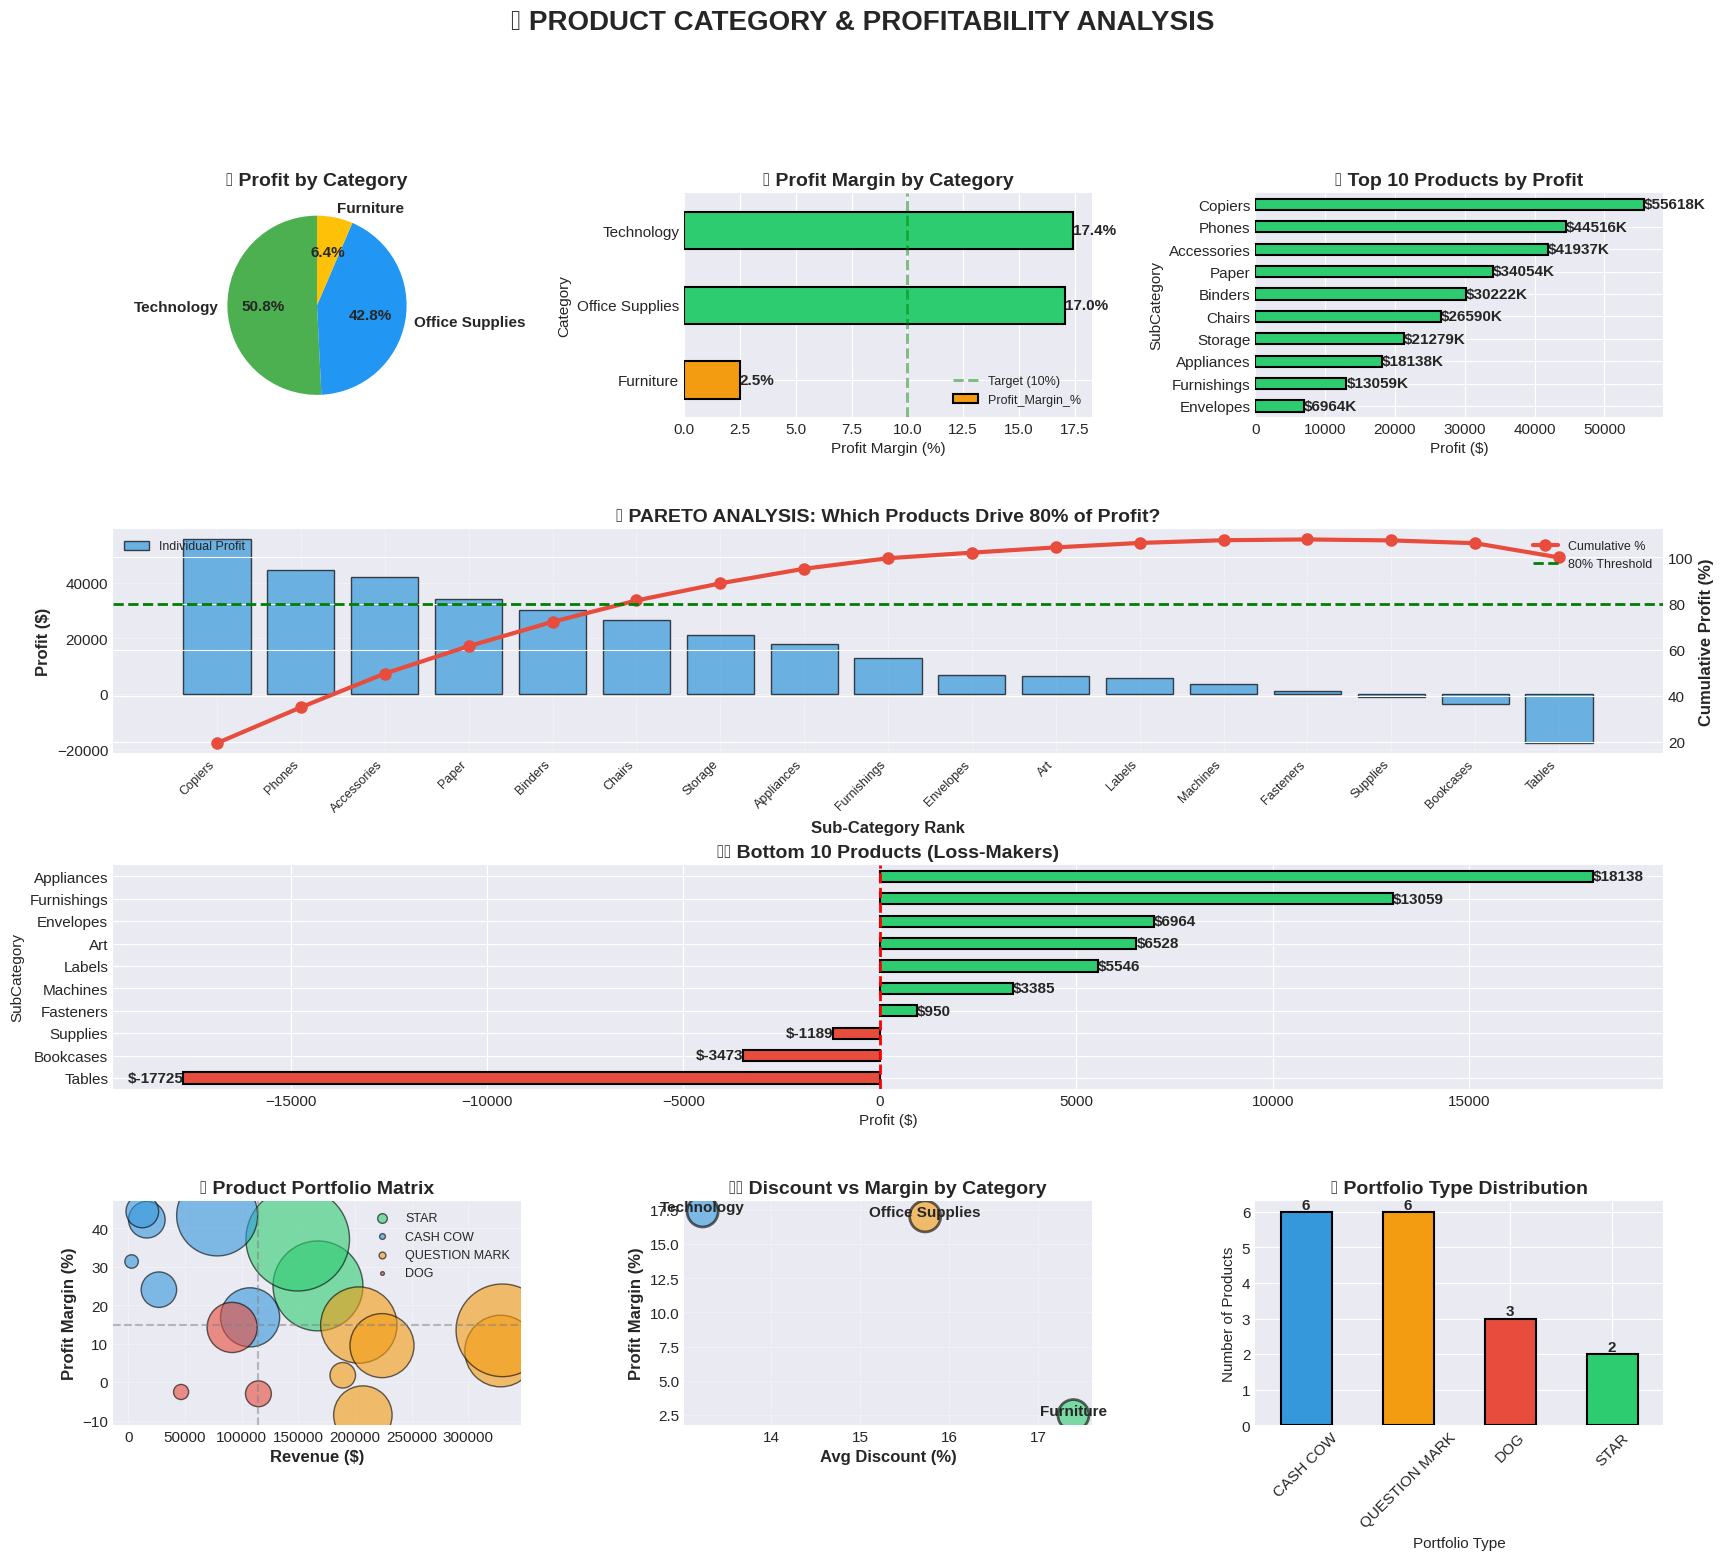

In [71]:
from typing import Dict, Tuple, Optional, List
from dataclasses import dataclass, field
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================

@dataclass
class ChartConfig:
    """Configuration for chart styling and colors"""
    FIGURE_SIZE: Tuple[int, int] = (20, 16)
    TITLE_FONT: Dict = field(default_factory=lambda: {'fontsize': 14, 'fontweight': 'bold'})
    LABEL_FONT: Dict = field(default_factory=lambda: {'fontsize': 11, 'fontweight': 'bold'})
    SUBTITLE_FONT: Dict = field(default_factory=lambda: {'fontsize': 12, 'fontweight': 'bold'})

    COLORS: Dict = field(default_factory=lambda: {
        'positive': '#2ecc71',
        'negative': '#e74c3c',
        'warning': '#f39c12',
        'info': '#3498db',
        'star': '#2ecc71',
        'cash_cow': '#3498db',
        'question_mark': '#f39c12',
        'dog': '#e74c3c',
        'pie_palette': ['#4CAF50', '#2196F3', '#FFC107', '#FF5722', '#9C27B0', '#00BCD4', '#8BC34A', '#FF9800', '#F44336'] # A diverse palette
    })

    GRID_SPEC: Dict = field(default_factory=lambda: {
        'hspace': 0.5, # Increased vertical space
        'wspace': 0.4  # Increased horizontal space
    })

config = ChartConfig()

# ============================================================================
# HELPER FUNCTIONS - FULLY DEBUGGED
# ============================================================================

def validate_dataframe(df: pd.DataFrame, required_columns: List[str]) -> None:
    """Validate that DataFrame contains all required columns"""
    if df is None or df.empty:
        raise ValueError("DataFrame is None or empty")
    missing = [col for col in required_columns if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

def safe_divide(numerator, denominator, default: float = 0) -> float:
    """Safely divide, handling all edge cases"""
    try:
        if denominator == 0 or pd.isna(denominator) or pd.isna(numerator):
            return default
        result = float(numerator) / float(denominator)
        if np.isnan(result) or np.isinf(result):
            return default
        return result
    except (TypeError, ZeroDivisionError, ValueError):
        return default

def get_profit_colors(values: pd.Series, threshold: float = 0) -> List[str]:
    """Generate colors based on profit values"""
    return [config.COLORS['positive'] if pd.notna(x) and x > threshold
            else config.COLORS['negative'] for x in values]

def get_margin_colors(values: pd.Series,
                      good_threshold: float = 10,
                      neutral_threshold: float = 0) -> List[str]:
    """Generate colors based on margin thresholds"""
    colors = []
    for x in values:
        if pd.isna(x):
            colors.append(config.COLORS['negative'])
        elif x > good_threshold:
            colors.append(config.COLORS['positive'])
        elif x > neutral_threshold:
            colors.append(config.COLORS['warning'])
        else:
            colors.append(config.COLORS['negative'])
    return colors

def add_bar_labels(ax, fmt: str = '.0f', prefix: str = '', suffix: str = '') -> None:
    """Add labels to bars - FIXED for all matplotlib versions"""
    try:
        for container in ax.containers:
            # Method 1: Try datavalues (matplotlib 3.4+)
            if hasattr(container, 'datavalues'):
                labels = [f'{prefix}{v:{fmt}}{suffix}' if pd.notna(v) else ''
                         for v in container.datavalues]
                ax.bar_label(container, labels=labels, fontweight='bold')
            # Method 2: Use get_height/get_width (older versions)
            elif len(container) > 0:
                # Check if horizontal or vertical bars
                first_bar = container[0]
                if hasattr(first_bar, 'get_width') and first_bar.get_width() != 0:
                    # Horizontal bars
                    values = [bar.get_width() for bar in container]
                else:
                    # Vertical bars
                    values = [bar.get_height() for bar in container]

                labels = [f'{prefix}{v:{fmt}}{suffix}' if pd.notna(v) and v != 0 else ''
                         for v in values]
                ax.bar_label(container, labels=labels, fontweight='bold')
    except Exception as e:
        print(f"Warning: Could not add bar labels: {e}")
        pass  # Silently fail if labeling doesn't work

def create_pie_chart(ax, data: pd.Series, title: str, colors: Optional[List[str]] = None) -> None:
    """Create standardized pie chart - FIXED"""
    if data.empty or data.sum() == 0:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=16)
        ax.set_title(title, **config.TITLE_FONT)
        return

    # Remove negative values for pie chart
    data_positive = data[data > 0]
    if data_positive.empty:
        ax.text(0.5, 0.5, 'No Positive Values', ha='center', va='center', fontsize=16)
        ax.set_title(title, **config.TITLE_FONT)
        return

    if colors is None:
        # Default pie colors if not explicitly provided
        num_slices = len(data_positive)
        colors = config.COLORS['pie_palette'][:num_slices] # Use a subset of the defined palette

    data_positive.plot(
        kind='pie',
        ax=ax,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors[:len(data_positive)],
        textprops=config.LABEL_FONT
    )
    ax.set_title(title, **config.TITLE_FONT)
    ax.set_ylabel('')

def create_horizontal_bar(ax, data: pd.Series, title: str, xlabel: str,
                         colors: Optional[List[str]] = None,
                         add_zero_line: bool = True) -> None:
    """Create standardized horizontal bar chart - FIXED"""
    if data.empty:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=16, transform=ax.transAxes)
        ax.set_title(title, **config.TITLE_FONT)
        return

    if colors is None:
        colors = get_profit_colors(data)

    data.plot(
        kind='barh',
        ax=ax,
        color=colors[:len(data)],
        edgecolor='black',
        linewidth=1.5
    )
    ax.set_title(title, **config.TITLE_FONT)
    ax.set_xlabel(xlabel)

    if add_zero_line and data.min() < 0:
        ax.axvline(x=0, color='red', linestyle='--', linewidth=2)

# ============================================================================
# MAIN VISUALIZATION CLASS - FULLY DEBUGGED
# ============================================================================

class ProductPortfolioVisualizer:
    """Encapsulates all product portfolio visualizations - DEBUGGED"""

    def __init__(self,
                 df: pd.DataFrame,
                 category_performance: pd.DataFrame,
                 subcat_performance: pd.DataFrame,
                 subcat_sorted: pd.DataFrame,
                 median_sales: float,
                 median_margin: float):
        """Initialize with data validation"""
        # Validate all inputs
        validate_dataframe(df, ['Category', 'Profit', 'Sales', 'Discount'])
        validate_dataframe(category_performance, ['Profit_Margin_%'])
        validate_dataframe(subcat_performance, ['Profit', 'Sales', 'Profit_Margin_%', 'Portfolio_Type'])

        self.df = df.copy()
        self.category_performance = category_performance.copy()
        self.subcat_performance = subcat_performance.copy()
        self.subcat_sorted = subcat_sorted.copy()
        self.median_sales = float(median_sales) if pd.notna(median_sales) else 0
        self.median_margin = float(median_margin) if pd.notna(median_margin) else 0

        print("✅ Data validation passed")
        print(f"   - Main DF: {self.df.shape}")
        print(f"   - Categories: {len(self.category_performance)}")
        print(f"   - Sub-categories: {len(self.subcat_performance)}")

    def create_dashboard(self, save_path: Optional[str] = None) -> plt.Figure:
        """Create complete dashboard with error handling"""
        fig = plt.figure(figsize=config.FIGURE_SIZE)
        gs = fig.add_gridspec(4, 3, **config.GRID_SPEC)

        plots = [
            ("Category Profit Pie", self._plot_category_profit_pie),
            ("Category Margin", self._plot_category_margin),
            ("Top Products", self._plot_top_products),
            ("Pareto Analysis", self._plot_pareto),
            ("Bottom Products", self._plot_bottom_products),
            ("Portfolio Matrix", self._plot_portfolio_matrix),
            ("Discount Impact", self._plot_discount_impact),
            ("Portfolio Distribution", self._plot_portfolio_distribution)
        ]

        for plot_name, plot_func in plots:
            try:
                plot_func(fig, gs)
                print(f"✅ {plot_name}: OK")
            except Exception as e:
                print(f"❌ {plot_name}: {str(e)}")
                # Continue with other plots

        plt.suptitle('📦 PRODUCT CATEGORY & PROFITABILITY ANALYSIS',
                    fontsize=20, fontweight='bold', y=0.995)

        try:
            plt.tight_layout()
        except:
            pass  # Ignore tight_layout errors

        if save_path:
            try:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
                print(f"✅ Dashboard saved to: {save_path}")
            except Exception as e:
                print(f"⚠️  Could not save file: {e}")

        return fig

    def _plot_category_profit_pie(self, fig, gs) -> None:
        """Plot 1: Category Profit Contribution - FIXED"""
        ax = fig.add_subplot(gs[0, 0])
        try:
            category_profit = self.df.groupby('Category')['Profit'].sum().sort_values(ascending=False)
            create_pie_chart(ax, category_profit, '📦 Profit by Category')
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center', transform=ax.transAxes)

    def _plot_category_margin(self, fig, gs) -> None:
        """Plot 2: Category Profit Margin - FIXED"""
        ax = fig.add_subplot(gs[0, 1])
        try:
            # FIXED: Reset index to avoid issues
            data = self.category_performance.copy()
            if not isinstance(data.index, pd.RangeIndex):
                data = data.reset_index()

            # Set Category as index for plotting
            if 'Category' in data.columns:
                data = data.set_index('Category')

            data_sorted = data.sort_values('Profit_Margin_%', ascending=True)
            colors = get_margin_colors(data_sorted['Profit_Margin_%'])

            create_horizontal_bar(ax, data_sorted['Profit_Margin_%'],
                                '📉 Profit Margin by Category',
                                'Profit Margin (%)', colors)

            ax.axvline(x=10, color='green', linestyle='--',
                      linewidth=2, alpha=0.5, label='Target (10%)')
            ax.legend(fontsize=9)
            add_bar_labels(ax, fmt='.1f', suffix='%')
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center', transform=ax.transAxes)

    def _plot_top_products(self, fig, gs) -> None:
        """Plot 3: Top Products - FIXED"""
        ax = fig.add_subplot(gs[0, 2])
        try:
            # FIXED: Work with copy and proper indexing
            data = self.subcat_performance.copy()
            n_items = min(10, len(data))

            if n_items == 0:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
                return

            top_n = data.nlargest(n_items, 'Profit').sort_values('Profit', ascending=True)

            # Set index for plotting
            if 'Sub_Category' in top_n.columns:
                top_n = top_n.set_index('Sub_Category')

            create_horizontal_bar(ax, top_n['Profit'],
                                f'🏆 Top {n_items} Products by Profit',
                                'Profit ($)',
                                colors=[config.COLORS['positive']] * len(top_n),
                                add_zero_line=False)
            add_bar_labels(ax, fmt='.0f', prefix='$', suffix='K')
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center', transform=ax.transAxes)

    def _plot_pareto(self, fig, gs) -> None:
        """Plot 4: Pareto Analysis - FIXED"""
        ax = fig.add_subplot(gs[1, :])
        try:
            n_items = min(20, len(self.subcat_sorted))
            if n_items == 0:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
                return

            pareto_data = self.subcat_sorted.head(n_items)
            ax_twin = ax.twinx()

            # Bar chart
            ax.bar(range(len(pareto_data)), pareto_data['Profit'],
                  color=config.COLORS['info'], edgecolor='black',
                  linewidth=1, alpha=0.7, label='Individual Profit')

            # Line chart
            ax_twin.plot(range(len(pareto_data)),
                        pareto_data['Cumulative_Profit_%'],
                        color=config.COLORS['negative'], marker='o',
                        linewidth=3, markersize=8, label='Cumulative %')

            ax_twin.axhline(y=80, color='green', linestyle='--',
                           linewidth=2, label='80% Threshold')

            ax.set_xlabel('Sub-Category Rank', **config.SUBTITLE_FONT)
            ax.set_ylabel('Profit ($)', **config.SUBTITLE_FONT)
            ax_twin.set_ylabel('Cumulative Profit (%)', **config.SUBTITLE_FONT)
            ax.set_title('📊 PARETO ANALYSIS: Which Products Drive 80% of Profit?',
                        **config.TITLE_FONT)

            ax.set_xticks(range(len(pareto_data)))
            ax.set_xticklabels(pareto_data.index, rotation=45, ha='right', fontsize=9)
            ax.legend(loc='upper left', fontsize=9)
            ax_twin.legend(loc='upper right', fontsize=9)
            ax.grid(alpha=0.3)
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center', transform=ax.transAxes)

    def _plot_bottom_products(self, fig, gs) -> None:
        """Plot 5: Bottom Products - FIXED"""
        ax = fig.add_subplot(gs[2, :])
        try:
            data = self.subcat_performance.copy()
            n_items = min(10, len(data))

            if n_items == 0:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
                return

            bottom_n = data.nsmallest(n_items, 'Profit').sort_values('Profit', ascending=True)

            if 'Sub_Category' in bottom_n.columns:
                bottom_n = bottom_n.set_index('Sub_Category')

            colors = get_profit_colors(bottom_n['Profit'])

            create_horizontal_bar(ax, bottom_n['Profit'],
                                f'⚠️ Bottom {n_items} Products (Loss-Makers)',
                                'Profit ($)', colors)
            add_bar_labels(ax, fmt='.0f', prefix='$')
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center', transform=ax.transAxes)

    def _plot_portfolio_matrix(self, fig, gs) -> None:
        """Plot 6: Portfolio Matrix - FIXED"""
        ax = fig.add_subplot(gs[3, 0])
        try:
            color_map = {
                'STAR': config.COLORS['star'],
                'CASH COW': config.COLORS['cash_cow'],
                'QUESTION MARK': config.COLORS['question_mark'],
                'DOG': config.COLORS['dog']
            }

            has_data = False
            for ptype, color in color_map.items():
                subset = self.subcat_performance[
                    self.subcat_performance['Portfolio_Type'] == ptype
                ]
                if len(subset) > 0:
                    has_data = True
                    # FIXED: Use abs() to handle negative profits
                    sizes = subset['Profit'].abs() * 0.1 # Reduced multiplier for point size
                    sizes = sizes.replace([np.inf, -np.inf], 100)  # Handle infinities
                    sizes = sizes.fillna(50)  # Handle NaN

                    ax.scatter(subset['Sales'], subset['Profit_Margin_%'],
                              s=sizes, c=color,
                              alpha=0.6, edgecolors='black', linewidth=1,
                              label=ptype)

            if not has_data:
                ax.text(0.5, 0.5, 'No Portfolio Data', ha='center', va='center', transform=ax.transAxes)
                return

            # Add median lines
            ax.axhline(y=self.median_margin, color='gray',
                      linestyle='--', linewidth=1.5, alpha=0.5)
            ax.axvline(x=self.median_sales, color='gray',
                      linestyle='--', linewidth=1.5, alpha=0.5)

            ax.set_title('📈 Product Portfolio Matrix', **config.TITLE_FONT)
            ax.set_xlabel('Revenue ($)', **config.SUBTITLE_FONT)
            ax.set_ylabel('Profit Margin (%)', **config.SUBTITLE_FONT)
            ax.legend(loc='best', fontsize=9, markerscale=0.1) # FIX: Further reduced markerscale
            ax.grid(alpha=0.3)
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center', transform=ax.transAxes)

    def _plot_discount_impact(self, fig, gs) -> None:
        """Plot 7: Discount Impact - FIXED"""
        ax = fig.add_subplot(gs[3, 1])
        try:
            discount_vs_margin = self.df.groupby('Category').agg({
                'Discount': 'mean',
                'Profit': 'sum',
                'Sales': 'sum'
            })

            # FIXED: Use safe_divide
            discount_vs_margin['Margin'] = discount_vs_margin.apply(
                lambda row: safe_divide(row['Profit'], row['Sales'], 0) * 100,
                axis=1
            )

            # FIXED: Handle color list length
            n_cats = len(discount_vs_margin)
            base_colors = ['#2ecc71', '#f39c12', '#3498db']
            colors_list = (base_colors * ((n_cats // len(base_colors)) + 1))[:n_cats]

            ax.scatter(discount_vs_margin['Discount'] * 100,
                      discount_vs_margin['Margin'], s=500,
                      c=colors_list, alpha=0.6,
                      edgecolors='black', linewidth=2)

            # Add labels
            for cat in discount_vs_margin.index:
                ax.annotate(cat,
                           (discount_vs_margin.loc[cat, 'Discount'] * 100,
                            discount_vs_margin.loc[cat, 'Margin']),
                           fontsize=11, fontweight='bold', ha='center')

            ax.set_title('🏷️ Discount vs Margin by Category', **config.TITLE_FONT)
            ax.set_xlabel('Avg Discount (%)', **config.SUBTITLE_FONT)
            ax.set_ylabel('Profit Margin (%)', **config.SUBTITLE_FONT)
            ax.grid(alpha=0.3)
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center', transform=ax.transAxes)

    def _plot_portfolio_distribution(self, fig, gs) -> None:
        """Plot 8: Portfolio Distribution - FIXED"""
        ax = fig.add_subplot(gs[3, 2])
        try:
            portfolio_counts = self.subcat_performance['Portfolio_Type'].value_counts()

            if portfolio_counts.empty:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=16)
                return

            color_map = {
                'STAR': config.COLORS['star'],
                'CASH COW': config.COLORS['cash_cow'],
                'QUESTION MARK': config.COLORS['question_mark'],
                'DOG': config.COLORS['dog']
            }
            colors = [color_map.get(ptype, config.COLORS['info'])
                     for ptype in portfolio_counts.index]

            portfolio_counts.plot(kind='bar', ax=ax, color=colors,
                                edgecolor='black', linewidth=1.5)
            ax.set_title('🎯 Portfolio Type Distribution', **config.TITLE_FONT)
            ax.set_xlabel('Portfolio Type')
            ax.set_ylabel('Number of Products')
            ax.tick_params(axis='x', rotation=45)
            add_bar_labels(ax, fmt='d')
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center', transform=ax.transAxes)

# ============================================================================
# USAGE EXAMPLE
# ============================================================================

visualizer = ProductPortfolioVisualizer(
        df=df,
        category_performance=category_performance,
        subcat_performance=subcat_performance,
        subcat_sorted=subcat_sorted,
        median_sales=median_sales,
        median_margin=median_margin
    )

fig = visualizer.create_dashboard(save_path='output.png')
plt.show()